In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import string
import seaborn as sns

import scipy as sp
from scipy import sparse
import sklearn
import umap

## add your packages ##

import time
import pickle
import memory_profiler
from collections import Counter
import matplotlib.colors as mcolors

%load_ext memory_profiler

from pathlib import Path

In [2]:
import black
import jupyter_black

jupyter_black.load(line_length=79)

In [3]:
variables_path = Path("../results/variables")
figures_path = Path("../results/figures")
data_path = Path("../datX")

In [4]:
plt.style.use("matplotlib_style.txt")

In [5]:
np.random.seed(42)

# Data

We are going to use the multimodal data from the paper Scala et al. 2021 (https://www.nature.com/articles/s41586-020-2907-3#Sec7). In particular, you will work with transcriptomics and electrophysiological data. From the transcriptomics gene counts, we will only work with the exon counts for simplicity. Some of the electrophysiological features are not high-quality recordings, therefore we will also filter them out for the project.

## Import

### Meta data

In [6]:
# META DATA

meta = pd.read_csv("data/m1_patchseq_meta_data.csv", sep="\t")

cells = meta["Cell"].values

layers = meta["Targeted layer"].values.astype("str")
cre = meta["Cre"].values
yields = meta["Yield (pg/µl)"].values
yields[yields == "?"] = np.nan
yields = yields.astype("float")
depth = meta["Soma depth (µm)"].values
depth[depth == "Slice Lost"] = np.nan
depth = depth.astype(float)
thickness = meta["Cortical thickness (µm)"].values
thickness[thickness == 0] = np.nan
thickness = thickness.astype(float)
traced = meta["Traced"].values == "y"
exclude = meta["Exclusion reasons"].values.astype(str)
exclude[exclude == "nan"] = ""

mice_names = meta["Mouse"].values
mice_ages = meta["Mouse age"].values
mice_cres = np.array(
    [
        c if c[-1] != "+" and c[-1] != "-" else c[:-1]
        for c in meta["Cre"].values
    ]
)
mice_ages = dict(zip(mice_names, mice_ages))
mice_cres = dict(zip(mice_names, mice_cres))

print("Number of cells with measured depth:    ", np.sum(~np.isnan(depth)))
print("Number of cells with measured thickness:", np.sum(~np.isnan(thickness)))
print("Number of reconstructed cells:          ", np.sum(traced))

sliceids = meta["Slice"].values
a, b = np.unique(sliceids, return_counts=True)
assert np.all(b <= 2)
print("Number of slices with two cells:        ", np.sum(b == 2))

# Some consistency checks
assert np.all(
    [
        np.unique(meta["Date"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse age"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse gender"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse genotype"].values[mice_names == m]).size == 1
        for m in mice_names
    ]
)
assert np.all(
    [
        np.unique(meta["Mouse"].values[sliceids == s]).size == 1
        for s in sliceids
    ]
)

Number of cells with measured depth:     1284
Number of cells with measured thickness: 1284
Number of reconstructed cells:           646
Number of slices with two cells:         69


### Transcriptomic data

In [7]:
# READ COUNTS

data_exons = pd.read_csv(
    "data/m1_patchseq_exon_counts.csv.gz", na_filter=False, index_col=0
)
exonCounts = data_exons.values.transpose()

assert all(cells == data_exons.columns)
genes = np.array(data_exons.index)

print("Count matrix shape (exon):  ", exonCounts.shape)

Count matrix shape (exon):   (1329, 42466)


In [8]:
data_exons

20171204_sample_2  20171204_sample_4  20171204_sample_5  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                  0                 68               1291   
0610009E02Rik                  0                  0                  0   
0610009L18Rik                  0                  0                  0   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171204_sample_6  20171207_sample_1  20171207_sample_2  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                 13   
0610009B22Rik                  0                  0                  0   
0610009E02Rik                  0                 30                 80   
0610009L18Rik                  0                  0                 99   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171207_sample_6  20171207_sample_7  20171219_sample_1  \
0610005C13Rik                  0                  0                  0   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                227                  0                  7   
0610009E02Rik                205                  0                  0   
0610009L18Rik                  0                380                  0   
...                          ...                ...                ...   
n-R5s96                        0                  0                  0   
n-R5s97                        0                  0                  0   
n-R5s98                        0                  0                  0   
n-TSaga9                       0                  0                  0   
n-TStga1                       0                  0                  0   

               20171219_sample_2  ...  20191114_sample_9  20200106_sample_1  \
0610005C13Rik                  0  ...                  0                  0   
0610006L08Rik                  0  ...                  0                  0   
0610009B22Rik                 10  ...                  0                271   
0610009E02Rik                 14  ...                  0                  0   
0610009L18Rik                  0  ...                  0                  0   
...                          ...  ...                ...                ...   
n-R5s96                        0  ...                  0                  0   
n-R5s97                        0  ...                  0                  0   
n-R5s98                        0  ...                  0                  0   
n-TSaga9                       0  ...                  0                  0   
n-TStga1                       0  ...                  0                  0   

               20200106_sample_4  20200106_sample_5  20200106_sample_6  \
0610005C13Rik                  0                  0                  1   
0610006L08Rik                  0                  0                  0   
0610009B22Rik                  0                  0                  0   
0610009E02Rik                  0                  0                  0   
0610009L18Rik                

In [9]:
# GENE LENGTH

data = pd.read_csv("data/gene_lengths.txt")
assert all(data["GeneID"] == genes)
exonLengths = data["exon_bp"].values
intronLengths = data["intron_bp"].values

### Cluster colors

In [10]:
cluster_colors = np.load("data/cluster_colors.npy")

In [11]:
cluster_colors.shape

(1329,)

In [12]:
rna_type = np.load("data/rna_type.npy", allow_pickle=True)

In [13]:
rna_type.shape

(1329,)

In [14]:
pickle_in = open("data/dict_rna_type_colors.pkl", "rb")
dict_rna_type_colors = pickle.load(pickle_in)

In [15]:
len(dict_rna_type_colors)

88

### Electrophysiological features

In [16]:
# EPHYS DATA

ephysData = pd.read_csv("data/m1_patchseq_ephys_features.csv")
ephysData = ephysData.sort_values(by="cell id")  # !!!!!!! ADDED !!!!!!!!
ephysNames = np.array(ephysData.columns[1:]).astype(str)
ephysCells = ephysData["cell id"].values
ephysData = ephysData.values[:, 1:].astype("float")
names2ephys = dict(zip(ephysCells, ephysData))
ephysData = np.array(
    [
        names2ephys[c] if c in names2ephys else ephysData[0] * np.nan
        for c in cells
    ]
)

print("Number of cells with ephys data:", np.sum(np.isin(cells, ephysCells)))

assert np.sum(~np.isin(ephysCells, cells)) == 0

Number of cells with ephys data: 1328


In [17]:
# Filtering ephys data

features_exclude = [
    "Afterdepolarization (mV)",
    "AP Fano factor",
    "ISI Fano factor",
    "Latency @ +20pA current (ms)",
    "Wildness",
    "Spike frequency adaptation",
    "Sag area (mV*s)",
    "Sag time (s)",
    "Burstiness",
    "AP amplitude average adaptation index",
    "ISI average adaptation index",
    "Rebound number of APs",
]

features_log = [
    "AP coefficient of variation",
    "ISI coefficient of variation",
    "ISI adaptation index",
    "Latency (ms)",
]

X = ephysData
ephysfeatures = X.copy()
print(X.shape)
for e in features_log:
    X[:, ephysNames == e] = np.log(X[:, ephysNames == e])
X = X[:, ~np.isin(ephysNames, features_exclude)]

keepcells = ~np.isnan(np.sum(X, axis=1))
X = X[keepcells, :]
print(X.shape)
X = X - X.mean(axis=0)
ephysData_filtered = X / X.std(axis=0)

features_exclude_set = set(features_exclude)  ## ADDED
ephysNames = np.array(
    [name for name in ephysNames if name not in features_exclude_set]
)  # ADDED

(1329, 29)
(1320, 17)


In [18]:
np.sum(np.isnan(ephysData_filtered))

0

# Research questions to investigate

**1) Inspect the data computing different statistics.** Keep in mind that the data is read counts, not UMI, so it is not supposed to follow a Poisson distribution.

**2) Normalize and transform the data.** There are several ways of normalizing the data (Raw, CPM, CPMedian, RPKM, see https://www.reneshbedre.com/blog/expression_units.html, https://translational-medicine.biomedcentral.com/articles/10.1186/s12967-021-02936-w). Take into account that there are certain normalizations that only make sense for UMI data. You also explored different transformations in the assignment (none, log, sqrt). Compare how the different transformations change the two-dimensional visualization.

**3) Two-dimensional visualization.** Try different methods (t-SNE, UMAP) / parameters (exagg., perplex.) for visualizations. Compare them using quantitative metrics (e.g., distance correlation, kNN accuracy/recall in high-dim vs. two-dim). Think about also using the electrophysiological features for different visualizations.

**4) Clustering.** Try different clustering methods (leiden, GMM). Implement a negative binomial mixture model. For that you can follow a similar method that what is described in Harris et al. 2018 (https://journals.plos.org/plosbiology/article?id=10.1371/journal.pbio.2006387#abstract0), with fixed r (r=2) and S (set of important genes). Evaluate your clustering results (metrics, compare number of clusters to original labels,...).

**5) Correlation in between electrophysiological features and genes/PCs.** Find correlations and a way of visualizing them.
    

### Introduction

## 1) Inspect The Data ##

### Meta data

In [19]:
# number of mice
mouse_all = meta["Mouse"].values.astype("str")
n_mice = len(np.unique(mouse_all))
print(f"The dataset consists of {n_mice} different mice.")

The dataset consists of 266 different mice.


In [20]:
# Gender
mouse_genders = meta["Mouse gender"].values.astype("str")
genders, gender_counts = np.unique(mouse_genders, return_counts=True)
percentages_gender = {
    gender: (count / len(mouse_genders)) * 100
    for gender, count in zip(genders, gender_counts)
}

for gender, percentage in percentages_gender.items():
    print(f"Percentage of {gender} mice: {percentage:.2f}%")

Percentage of F mice: 51.47%
Percentage of M mice: 48.53%


In [21]:
# Genotype
mouse_genotypes = meta["Mouse genotype"].values.astype("str")
genotype_counts = Counter(mouse_genotypes)
genotype_percentages = {
    genotype: (count / len(mouse_genotypes)) * 100
    for genotype, count in genotype_counts.items()
}
print(genotype_percentages)

# Combine all genotypes with less than 5%
genotype_summary = {
    k: v
    for k, v in genotype_counts.items()
    if v >= 0.05 * len(mouse_genotypes)
}
other_genotypes_count = sum(
    v for k, v in genotype_counts.items() if v < 0.05 * len(mouse_genotypes)
)
genotype_summary["Other genotypes"] = other_genotypes_count

# Custom colormap
cmap = plt.get_cmap("Blues")
norm = mcolors.Normalize(vmin=0, vmax=len(genotype_summary))
colors = [cmap(norm(i)) for i in range(len(genotype_summary))]

{'Pvalb-Cre/wt; Ai9/wt': 29.044394281414597, 'Sst-IRES-Cre/wt; Ai9/wt': 28.74341610233258, 'Viaat-Cre/wt; Ai9/wt': 8.577878103837472, 'wt/wt': 9.029345372460497, 'Scnn1a-Tg3-Cre/wt; Ai9/wt': 0.07524454477050413, 'Vip-IRES-Cre/wt; Ai9/wt': 17.155756207674944, 'Vipr2-IRES2-Cre-D/wt; Ai9/wt': 3.235515425131678, 'Slc17a8-IRES2-Cre-D/wt; Ai9/wt': 2.784048156508653, 'Npy-Cre/wt; Ai9/wt': 0.6772009029345373, 'Vglut3-Cre/wt; Ai9/wt': 0.4514672686230248, 'Gnb4-IRES2-CreER2-D knock-in/wt; Ai9/wt': 0.2257336343115124}


In [22]:
# Age
mouse_ages = list(mice_ages.values())
mean_age = np.mean(mouse_ages)

In [23]:
# Normalized soma depth
filtered_thickness = thickness[~np.isnan(thickness) & ~np.isnan(depth)]
filtered_depth = depth[~np.isnan(thickness) & ~np.isnan(depth)]

# Normalize depth by thickness
normalized_depth = filtered_depth / filtered_thickness
mean_depth = np.mean(normalized_depth)

/var/folders/5j/y5kkrfqd203frqztz88nnmqr0000gn/T/ipykernel_77052/1631768841.py:40: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


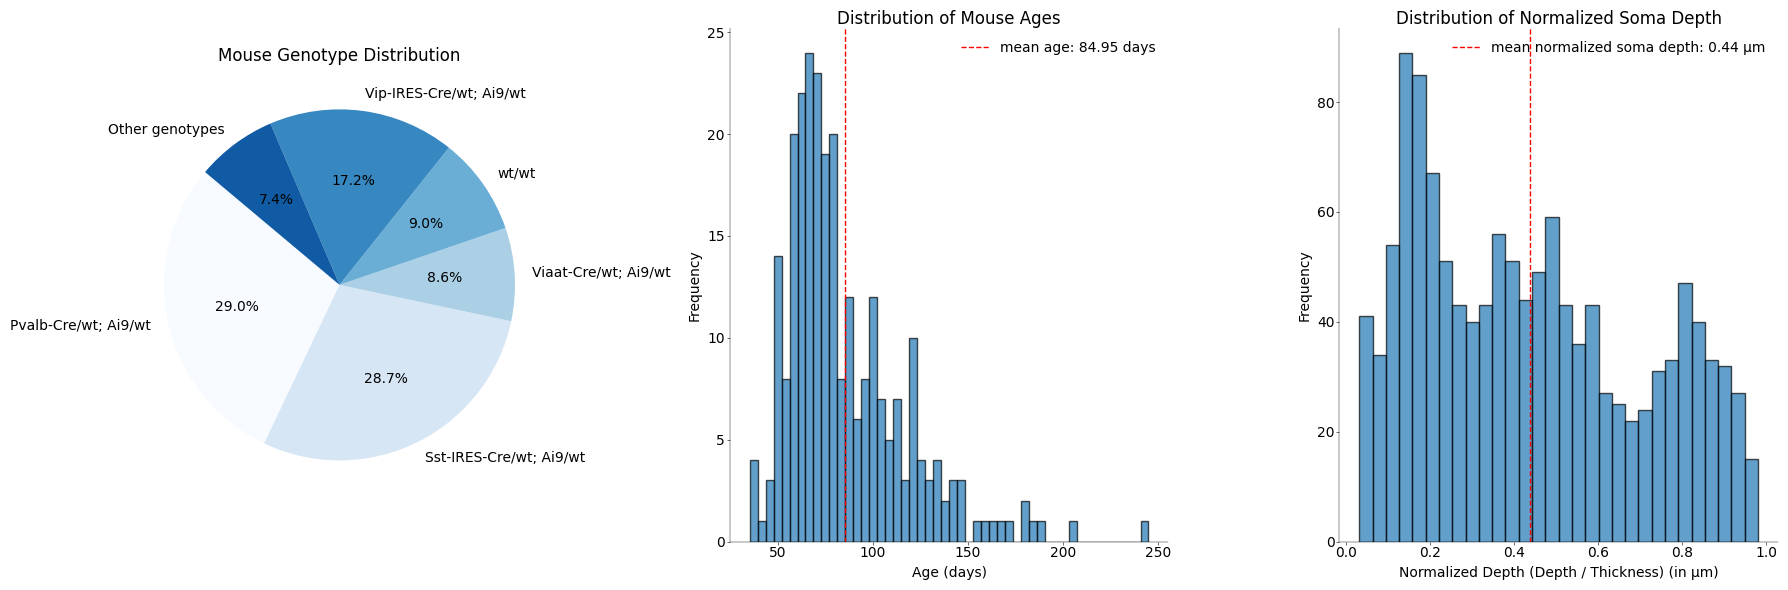

In [24]:
# Plot
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.pie(
    genotype_summary.values(),
    labels=genotype_summary.keys(),
    autopct="%1.1f%%",
    startangle=140,
    colors=colors,
)
plt.title("Mouse Genotype Distribution")

plt.subplot(1, 3, 2)
plt.hist(mouse_ages, bins=50, alpha=0.7, edgecolor="black")
plt.axvline(
    mean_age,
    color="r",
    linestyle="dashed",
    label=f"mean age: {mean_age:.2f} days",
)
plt.title("Distribution of Mouse Ages")
plt.xlabel("Age (days)")
plt.ylabel("Frequency")
plt.legend()

plt.subplot(1, 3, 3)
plt.hist(normalized_depth, bins=30, alpha=0.7, edgecolor="black")
plt.axvline(
    mean_depth,
    color="r",
    linestyle="dashed",
    label=f"mean normalized soma depth: {mean_depth:.2f} µm",
)
plt.xlabel("Normalized Depth (Depth / Thickness) (in µm)")
plt.ylabel("Frequency")
plt.title("Distribution of Normalized Soma Depth")
plt.legend()

plt.tight_layout()
plt.show()

The datasets consists of experiments that were being made on a mouse population of n=266 mice (48.53% / 51.47% male/female) with an average age of 84.95 days (see more detailed mouse age distribution above). The distribution of mouse genotypes can be obtained in th epie chart above ("other genotypes" summarizes all genotypes that have an occurance of less than 5%. Those are in particular Scnn1a-Tg3-Cre/wt; Ai9/wt  (0.08%), Vipr2-IRES2-Cre-D/wt; Ai9/wt (3.24%), Slc17a8-IRES2-Cre-D/wt; Ai9/wt (2.78%), Npy-Cre/wt; Ai9/wt (0.68%), Vglut3-Cre/wt; Ai9/wt (0.45%), Gnb4-IRES2-CreER2-D knock-in/wt; Ai9/wt (0.23%)).

### Transcriptomics data

In [25]:
# gene expression analysis

gene_means = np.mean(exonCounts, axis=0)
gene_means_sorted_ids = np.argsort(-gene_means)
gene_medians = np.median(exonCounts, axis=0)
gene_var = np.var(exonCounts, axis=0)

# genes that were not expressed at all
n_not_expressed = np.shape(np.where(np.sum(exonCounts, axis=0) == 0))[1]

# number of cells that express a certain gene
n_cells_per_genes = np.sum(exonCounts > 0, axis=0)
n_cells_per_genes_sorted_ids = np.argsort(-n_cells_per_genes)

/var/folders/5j/y5kkrfqd203frqztz88nnmqr0000gn/T/ipykernel_77052/1144123460.py:27: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


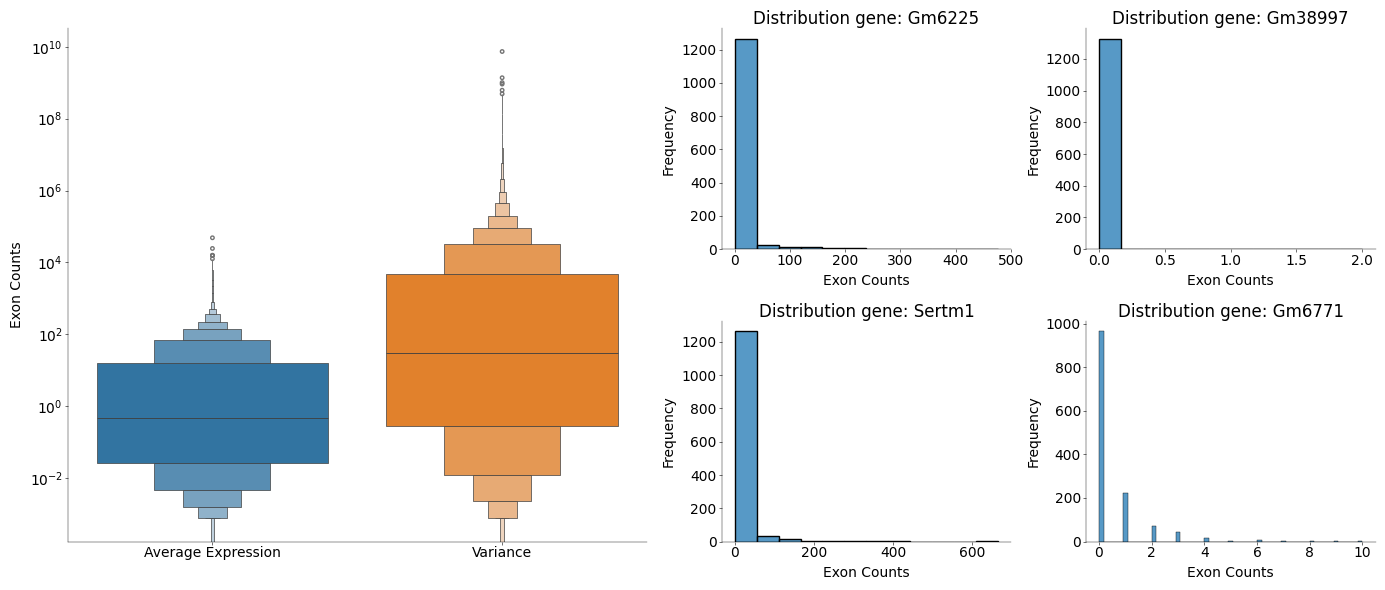

Avg exon counts of all genes: 37.74 (std: 344.96)
Avg number of cells that express a certain gene: 211.76 (std: 314.99)


The 5 most expressed genes on average:
1: CT010467.1: 	 48376.94 (std: 86179.43)
2: Gm26917: 	 24400.66 (std: 37173.28)
3: ERCC-00074: 	 15767.69 (std: 30343.80)
4: ERCC-00130: 	 15719.69 (std: 31804.46)
5: Snhg11: 	 15422.83 (std: 18551.54)
269 genes were not expressed at all


The 5 genes that were expressed by the most cells:
1: CT010467.1: 	 1327
2: mt-Rnr2: 	 1323
3: Lars2: 	 1322
4: Gm20388: 	 1321
5: Rn7s1: 	 1321


In [26]:
# Define the GridSpec layout
fig = plt.figure(figsize=(14, 6))
gs = plt.GridSpec(2, 3, width_ratios=[2, 1, 1], height_ratios=[1, 1])

ax_main = fig.add_subplot(gs[:, 0])
sns.boxenplot(data=[gene_means, gene_var], ax=ax_main)
ax_main.set_xticks([0, 1])
ax_main.set_xticklabels(["Average Expression", "Variance"])
ax_main.set_ylabel("Exon Counts")
ax_main.set_yscale("log")

np.random.seed(1)
random_genes = np.random.choice(data_exons.index, 4, replace=False)

axes = []
for i in range(2):
    for j in range(1, 3):
        ax = fig.add_subplot(gs[i, j])
        axes.append(ax)

for idx, gene in enumerate(random_genes):
    ax = axes[idx]
    sns.histplot(data_exons.loc[gene], kde=False, ax=ax)
    ax.set_title(f"Distribution gene: {gene}")
    ax.set_xlabel("Exon Counts")
    ax.set_ylabel("Frequency")
plt.tight_layout()
plt.show()

# print some results
print(
    f"Avg exon counts of all genes: {np.mean(gene_means):.2f} (std: {np.std(gene_means):.2f})"
)
print(
    f"Avg number of cells that express a certain gene: {np.mean(n_cells_per_genes):.2f} (std: {np.std(n_cells_per_genes):.2f})"
)
print("\n")
print(f"The 5 most expressed genes on average:")
for i in range(5):
    print(
        f"{i+1}: {data_exons.index[gene_means_sorted_ids[i]]}: \t {gene_means[gene_means_sorted_ids[i]]:.2f} (std: {np.std(exonCounts[:, gene_means_sorted_ids[i]]):.2f})"
    )
print(f"{n_not_expressed} genes were not expressed at all")
print("\n")
print(f"The 5 genes that were expressed by the most cells:")
for i in range(5):
    print(
        f"{i+1}: {data_exons.index[n_cells_per_genes_sorted_ids[i]]}: \t {n_cells_per_genes[n_cells_per_genes_sorted_ids[i]]}"
    )

In [27]:
# cell specific expression

# how many different genes does a cell express on average
n_genes_per_cell = np.sum(data_exons.values > 0, axis=0)
n_genes_per_cell_sorted_ids = np.argsort(-n_genes_per_cell)

# get sequencing depth for each cell
seq_depth = np.sum(data_exons.values, axis=0)

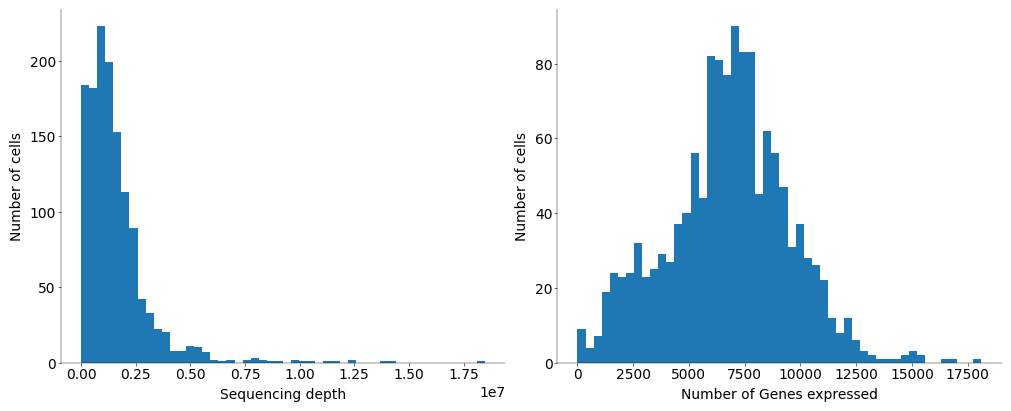

Average number of genes expressed over all cells: 6766.39 (std: 2742.47)
The 5 cells that expressed the most number of different genes:
0: 0610010F05Rik: 	 18118
1: 1110017D15Rik: 	 16845
2: 0610009L18Rik: 	 16310
3: 0610012G03Rik: 	 15527
4: 1110002J07Rik: 	 15372


The 5 cells that expressed the least number of different genes:
1: 1600014C23Rik: 	 5
2: 1700120G07Rik: 	 24
3: 1700120C18Rik: 	 26
4: 1700010B08Rik: 	 45
5: 1700080N15Rik: 	 69


In [28]:
# plot
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].hist(seq_depth, bins=50)
ax[0].set_xlabel("Sequencing depth")
ax[0].set_ylabel("Number of cells")
ax[1].hist(n_genes_per_cell, bins=50)
ax[1].set_xlabel("Number of Genes expressed")
ax[1].set_ylabel("Number of cells")
plt.show()

# print results
print(
    f"Average number of genes expressed over all cells: {np.mean(n_genes_per_cell):.2f} (std: {np.std(n_genes_per_cell):.2f})"
)
print(f"The 5 cells that expressed the most number of different genes:")
for i in range(5):
    print(
        f"{i}: {data_exons.index[n_genes_per_cell_sorted_ids[i]]}: \t {n_genes_per_cell[n_genes_per_cell_sorted_ids[i]]}"
    )
print("\n")
print(f"The 5 cells that expressed the least number of different genes:")
for i in range(1, 6):
    print(
        f"{i}: {data_exons.index[n_genes_per_cell_sorted_ids[-i]]}: \t {n_genes_per_cell[n_genes_per_cell_sorted_ids[-i]]}"
    )

## 2) Normalize and Transform the Data ##

In [29]:
def cpm(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = (counts / seq_depth[:, np.newaxis]) * 1e6
    return normed


def cpmedian(counts):
    seq_depth = np.sum(counts, axis=1)
    normed = counts / seq_depth[:, np.newaxis] * np.median(seq_depth)
    return normed


def rpkm(
    counts, lengths
):  ## Taken from https://www.oreilly.com/library/view/elegant-scipy/9781491922927/ch01.html
    """Calculate reads per kilobase transcript per million reads.

    RPKM = (10^9 * C) / (N * L)

    Where:
    C = Number of reads mapped to a gene
    N = Total mapped reads in the experiment
    L = Exon length in base pairs for a gene

    Parameters
    ----------
    counts: array, shape (N_genes, N_samples)
        RNAseq (or similar) count data where columns are individual samples
        and rows are genes.
    lengths: array, shape (N_genes,)
        Gene lengths in base pairs in the same order
        as the rows in counts.

    Returns
    -------
    normed : array, shape (N_genes, N_samples)
        The RPKM normalized counts matrix.
    """
    N = np.sum(counts, axis=0)  # sum each column to get total reads per sample
    L = lengths
    C = counts

    normed = 1e9 * C / (N[np.newaxis, :] * L[:, np.newaxis])

    return normed.T


# exonCounts = sklearn.preprocessing.normalize(exonCounts)
cpm = cpm(exonCounts)
cpmedian = cpmedian(exonCounts)
rpkm = rpkm(exonCounts.T, exonLengths)

In [30]:
## Transforms
def sqrt_transform(counts):
    return np.sqrt(counts)


def log_transform(counts):
    return np.log2(counts + 1)

## 3) Two-Dimensional visualization ##

In [31]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Condition            dist_corr  rank_corr  knn acc    density var
-----------------------------------------------------------------
Raw + None           0.81       0.75       0.41       14.33     
Raw + Log            0.37       0.13       0.12       26.45     
Raw + Sqrt           0.61       0.42       0.23       13.41     
CPM + None           0.86       0.77       0.42       11.13     
CPM + Log            0.43       0.16       0.10       16.42     
CPM + Sqrt           0.57       0.28       0.24       4.40      
CPMedian + None      0.86       0.77       0.42       10.00     
CPMedian + Log       0.42       0.15       0.10       15.79     
CPMedian + Sqrt      0.57       0.28       0.24       4.48      
RPKM + None          0.85       0.82       0.42       4.68      
RPKM + Log           0.31       0.07       0.07       23.96     
RPKM + Sqrt          0.80       0.72       0.28       6.53      


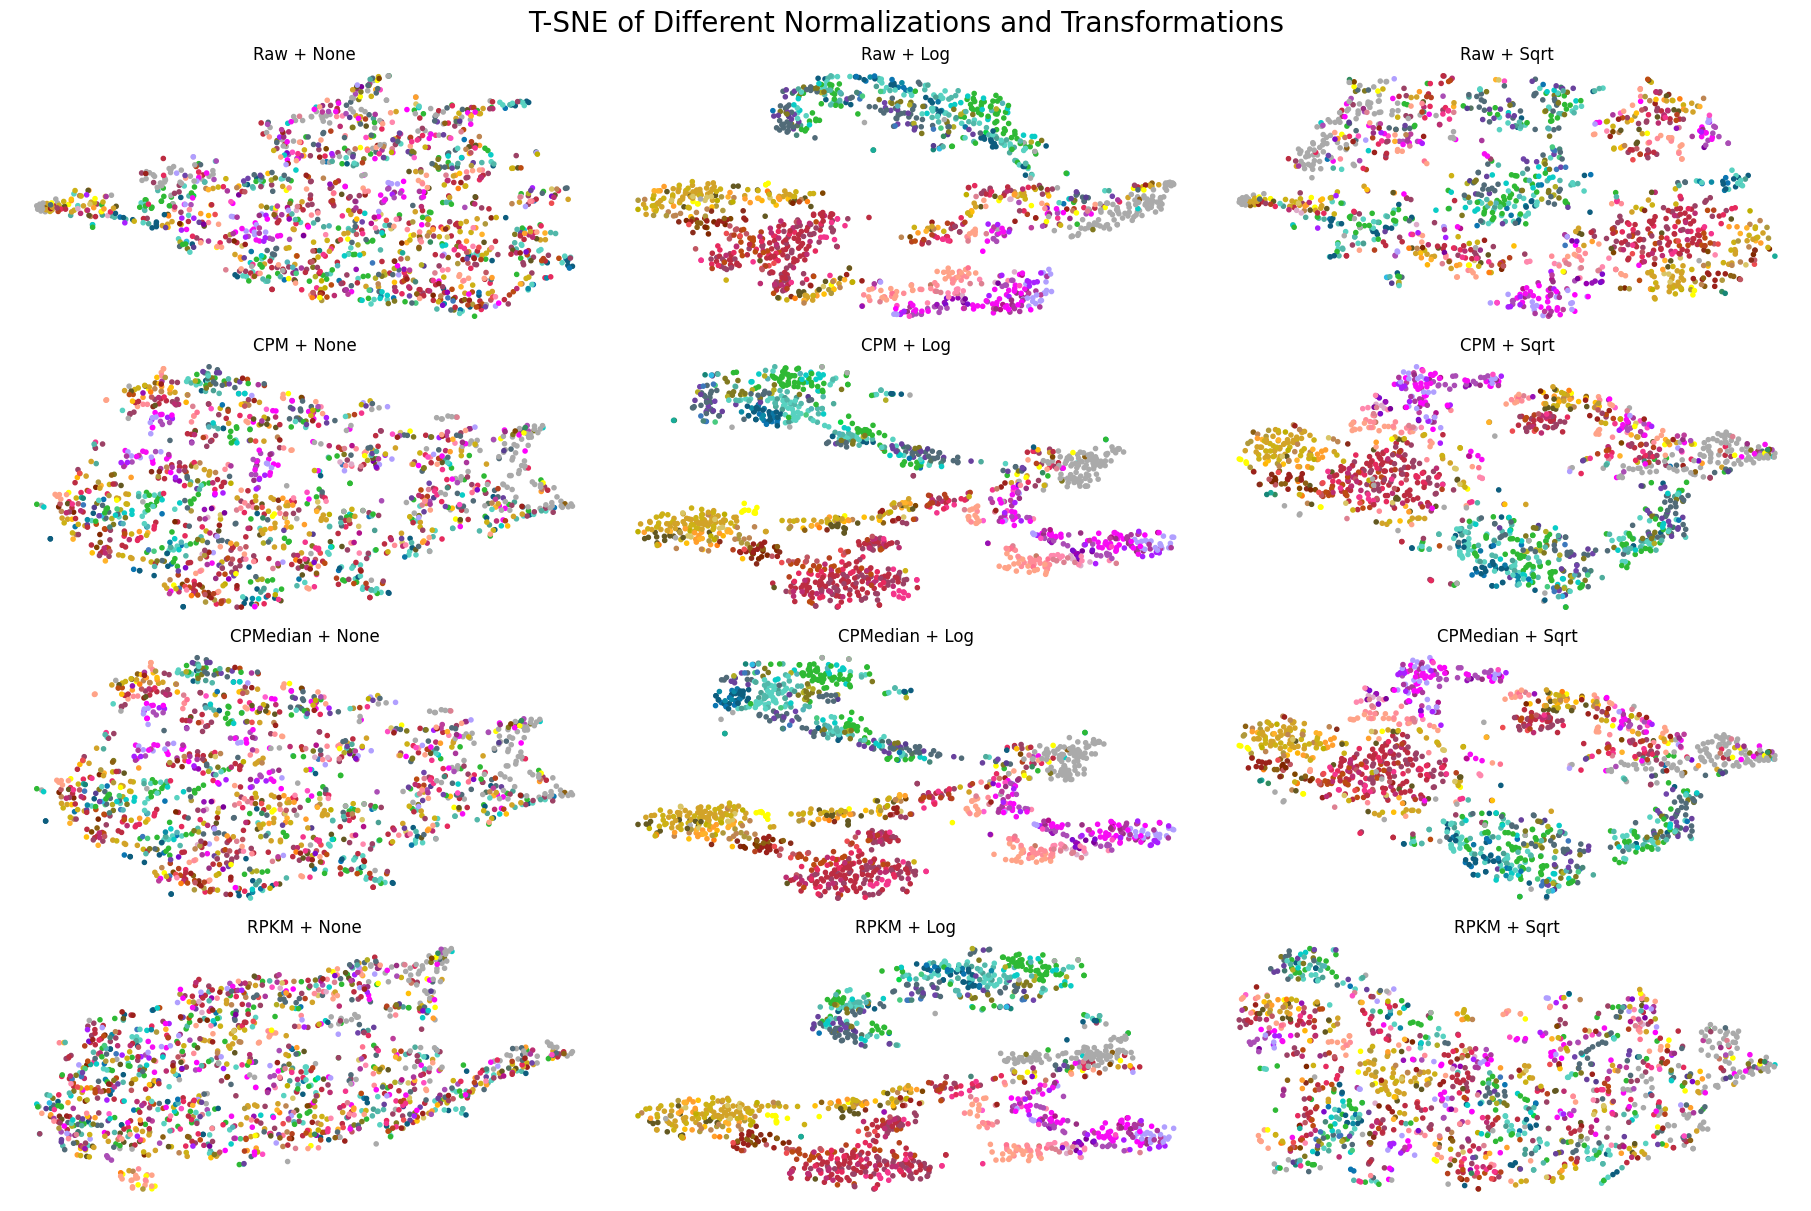

In [32]:
from scipy.spatial.distance import pdist, squareform
from scipy.stats import rankdata, spearmanr
from sklearn.metrics import silhouette_score


def distance_covariance(X, Y):
    n = X.shape[0]
    X -= X.mean(axis=0) + X.mean(axis=1)[:, np.newaxis] - X.mean()
    Y -= Y.mean(axis=0) + Y.mean(axis=1)[:, np.newaxis] - Y.mean()
    dcov = np.sqrt((X * Y).sum() / (n * n))
    return dcov


def distance_correlation(X, Y):
    dcov_XY = distance_covariance(X, Y)
    dcov_XX = distance_covariance(X, X)
    dcov_YY = distance_covariance(Y, Y)
    dcor = dcov_XY / np.sqrt(dcov_XX * dcov_YY)
    return dcor


normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "T-SNE of Different Normalizations and Transformations", fontsize=20
)

measures = np.zeros((len(normalizations), len(transformations), 4))

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = PCA(n_components=50).fit_transform(data_transformed)
        tsne = TSNE(n_components=2, perplexity=30)
        tsne_results = tsne.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
        ax.set_title(f"{norm_name} + {trans_name}", fontsize=12)
        ax.axis("off")

        # calculate pairwise (cell) distances in 2d and high dimensional space
        dist_hd = squareform(pdist(data))
        dist_ld = squareform(pdist(tsne_results))

        # calculate distance correlations
        dcor = distance_correlation(dist_hd, dist_ld)
        measures[i, j, 0] = dcor

        # calculate distance ranks
        ranks_hd = rankdata(dist_hd)
        ranks_ld = rankdata(dist_ld)
        # calculate correlation of ranks
        spearman_corr, _ = spearmanr(ranks_hd, ranks_ld)
        measures[i, j, 1] = spearman_corr

        # calculate the knn for each cell in high and low dimensional space
        k = 15
        knn_hd = np.array([np.argsort(x)[1 : k + 1] for x in dist_hd])
        knn_ld = np.array([np.argsort(x)[1 : k + 1] for x in dist_ld])
        # calculate the number of overlapping neighbors
        accuracy = np.sum(
            [len(set(x) & set(y)) for x, y in zip(knn_hd, knn_ld)]
        ) / (knn_hd.shape[0] * k)
        measures[i, j, 2] = accuracy

        # calculate point density variance
        mins = np.min(tsne_results, axis=0)
        maxs = np.max(tsne_results, axis=1)
        # kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(tsne_results)
        x_grid = np.linspace(mins[0] - 1, maxs[0] + 1, 20)
        y_grid = np.linspace(mins[1] - 1, maxs[1] + 1, 20)
        densities = np.zeros(len(x_grid) * len(y_grid))
        pos = 0
        for x, _ in enumerate(x_grid[:-1]):
            for y, _ in enumerate(y_grid[:-1]):
                densities[pos] = np.sum(
                    (
                        (tsne_results[:, 0] >= x_grid[x])
                        & (tsne_results[:, 0] < x_grid[x + 1])
                        & (tsne_results[:, 1] >= y_grid[y])
                        & (tsne_results[:, 1] < y_grid[y + 1])
                    )
                )
                pos += 1
        measures[i, j, 3] = np.var(densities)


# print measures as table
print(
    f"{'Condition':<20} {'dist_corr':<10} {'rank_corr':<10} {'knn acc':<10} {'density var':<10}"
)
print("-" * 65)
for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        condition = f"{norm_name} + {trans_name}"
        print(
            f"{condition:<20} {measures[i, j, 0]:<10.2f} {measures[i, j, 1]:<10.2f} {measures[i, j, 2]:<10.2f} {measures[i, j, 3]:<10.2f}"
        )

In [33]:
import umap.umap_ as umap

/opt/homebrew/Caskroom/miniconda/base/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/Caskroom/miniconda/base/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/Caskroom/miniconda/base/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
/opt/homebrew/Caskroom/miniconda/base/envs/nds_env/lib/python3.10/site-packages

Condition            dist_corr  rank_corr  knn acc    density var
-----------------------------------------------------------------
Raw + None           0.82       0.78       0.34       0.82      
Raw + Log            0.65       0.41       0.25       15.36     
Raw + Sqrt           0.73       0.50       0.29       28.31     
CPM + None           0.87       0.78       0.38       4.41      
CPM + Log            0.72       0.49       0.31       51.96     
CPM + Sqrt           0.75       0.51       0.34       12.98     
CPMedian + None      0.87       0.78       0.38       7.41      
CPMedian + Log       0.67       0.47       0.29       61.85     
CPMedian + Sqrt      0.74       0.50       0.35       9.92      
RPKM + None          0.87       0.84       0.39       4.47      
RPKM + Log           0.66       0.46       0.30       61.39     
RPKM + Sqrt          0.84       0.66       0.32       4.36      


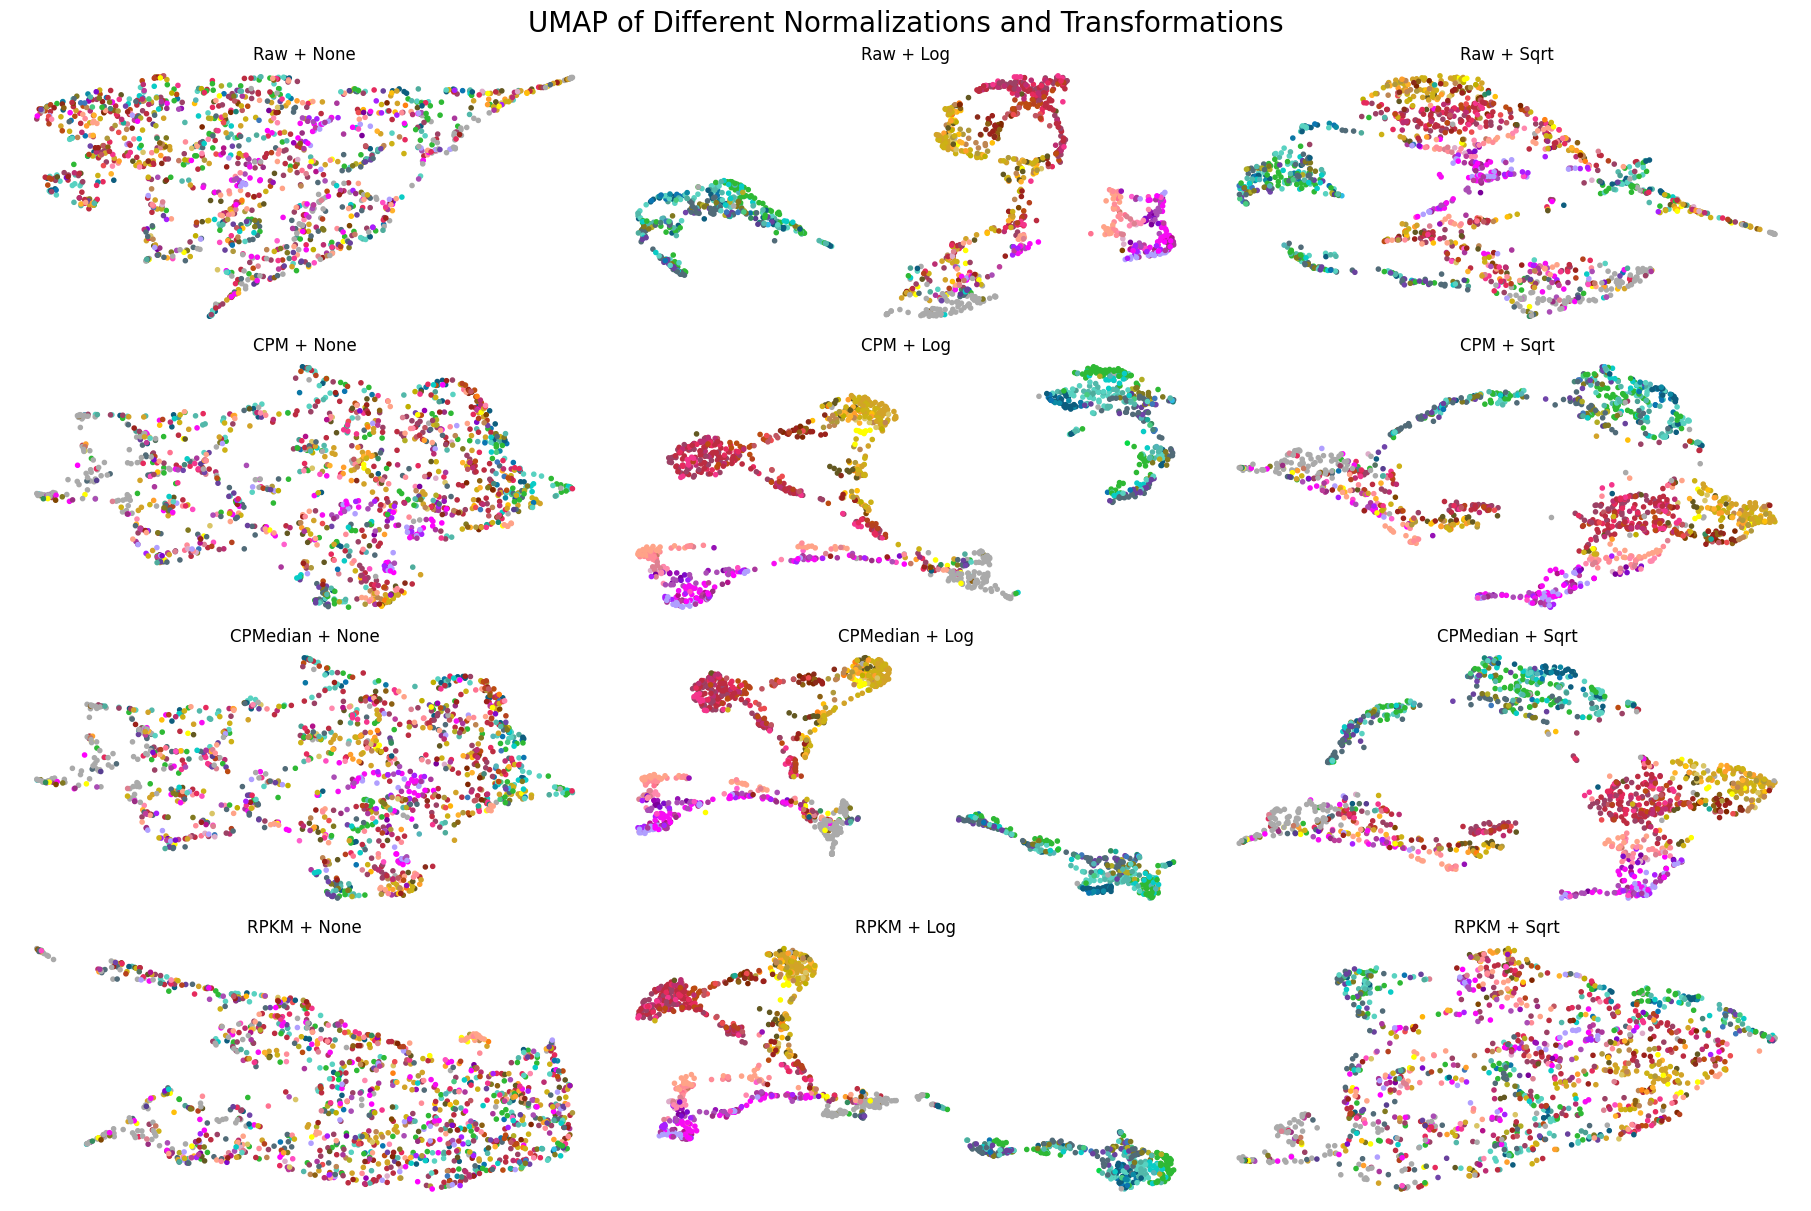

In [34]:
normalizations = {
    "Raw": exonCounts,
    "CPM": cpm,
    "CPMedian": cpmedian,
    "RPKM": rpkm,
}

transformations = {
    "None": lambda x: x,
    "Log": log_transform,
    "Sqrt": sqrt_transform,
}

fig, axes = plt.subplots(
    len(normalizations), len(transformations), figsize=(18, 12)
)
fig.suptitle(
    "UMAP of Different Normalizations and Transformations", fontsize=20
)

measures = np.zeros((len(normalizations), len(transformations), 4))

for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        data = norm_data[:, gene_var > np.sort(gene_var)[-501]]
        data_transformed = trans_func(data)
        pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
            data_transformed
        )
        umap_model = umap.UMAP(random_state=7)
        umap_results = umap_model.fit_transform(pca_result)

        ax = axes[i, j]
        ax.scatter(umap_results[:, 0], umap_results[:, 1], c=cluster_colors)
        ax.set_title(f"{norm_name} + {trans_name}", fontsize=12)
        ax.axis("off")

        # calculate pairwise (cell) distances in 2d and high dimensional space
        dist_hd = squareform(pdist(data_transformed))
        dist_ld = squareform(pdist(umap_results))

        # calculate distance correlations
        dcor = distance_correlation(dist_hd, dist_ld)
        measures[i, j, 0] = dcor

        # calculate distance ranks
        ranks_hd = rankdata(dist_hd)
        ranks_ld = rankdata(dist_ld)
        # calculate correlation of ranks
        spearman_corr, _ = spearmanr(ranks_hd, ranks_ld)
        measures[i, j, 1] = spearman_corr

        # calculate the knn for each cell in high and low dimensional space
        k = 15
        knn_hd = np.array([np.argsort(x)[1 : k + 1] for x in dist_hd])
        knn_ld = np.array([np.argsort(x)[1 : k + 1] for x in dist_ld])
        # calculate the number of overlapping neighbors
        accuracy = np.sum(
            [len(set(x) & set(y)) for x, y in zip(knn_hd, knn_ld)]
        ) / (knn_hd.shape[0] * k)
        measures[i, j, 2] = accuracy

        # calculate point density variance
        mins = np.min(umap_results, axis=0)
        maxs = np.max(umap_results, axis=1)
        # kde = KernelDensity(kernel="gaussian", bandwidth=10).fit(tsne_results)
        x_grid = np.linspace(mins[0] - 1, maxs[0] + 1, 20)
        y_grid = np.linspace(mins[1] - 1, maxs[1] + 1, 20)
        densities = np.zeros(len(x_grid) * len(y_grid))
        pos = 0
        for x, _ in enumerate(x_grid[:-1]):
            for y, _ in enumerate(y_grid[:-1]):
                densities[pos] = np.sum(
                    (
                        (umap_results[:, 0] >= x_grid[x])
                        & (umap_results[:, 0] < x_grid[x + 1])
                        & (umap_results[:, 1] >= y_grid[y])
                        & (umap_results[:, 1] < y_grid[y + 1])
                    )
                )
                pos += 1
        measures[i, j, 3] = np.var(densities)


# print measures as table
print(
    f"{'Condition':<20} {'dist_corr':<10} {'rank_corr':<10} {'knn acc':<10} {'density var':<10}"
)
print("-" * 65)
for i, (norm_name, norm_data) in enumerate(normalizations.items()):
    for j, (trans_name, trans_func) in enumerate(transformations.items()):
        condition = f"{norm_name} + {trans_name}"
        print(
            f"{condition:<20} {measures[i, j, 0]:<10.2f} {measures[i, j, 1]:<10.2f} {measures[i, j, 2]:<10.2f} {measures[i, j, 3]:<10.2f}"
        )


plt.show()

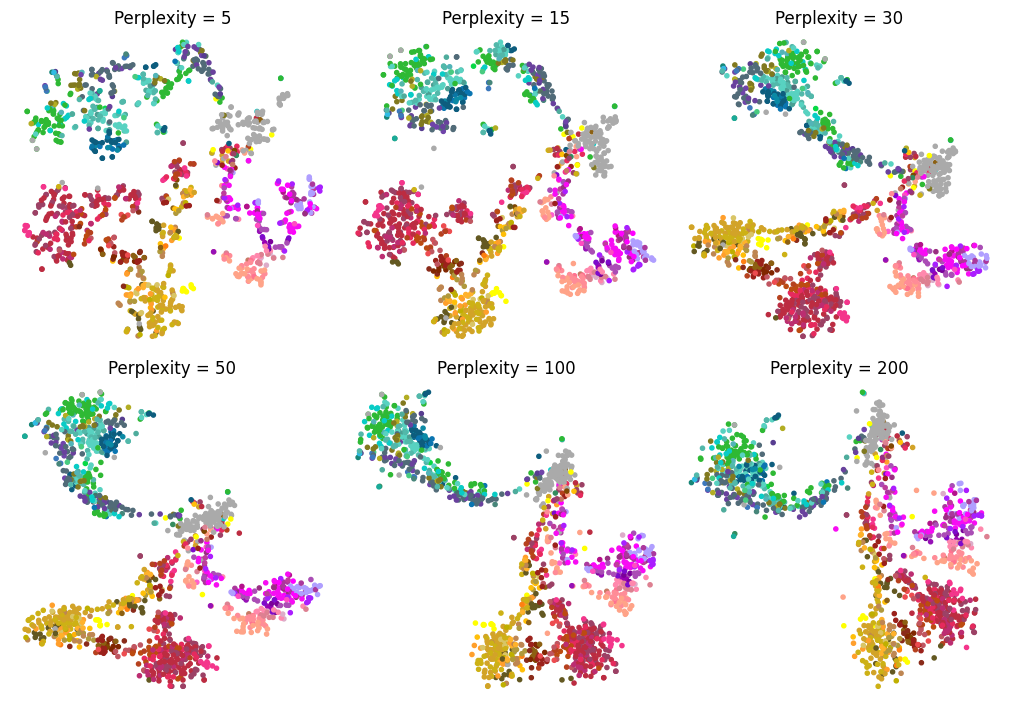

In [35]:
data_final = log_transform(cpmedian)
data_final = data_final[:, gene_var > np.sort(gene_var)[-501]]

perplexities = [5, 15, 30, 50, 100, 200]
fig, axes = plt.subplots(2, 3, figsize=(10, 7))
axes_flat = np.ravel(axes)

for idx, perplexity in enumerate(perplexities):
    ax = axes_flat[idx]

    pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
        data_final
    )
    tsne = sklearn.manifold.TSNE(
        n_components=2, perplexity=perplexity, random_state=7
    )
    tsne_results = tsne.fit_transform(pca_result)

    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
    ax.set_title(
        f"Perplexity = {perplexity}",
        fontsize=12,
    )
    ax.axis("off")

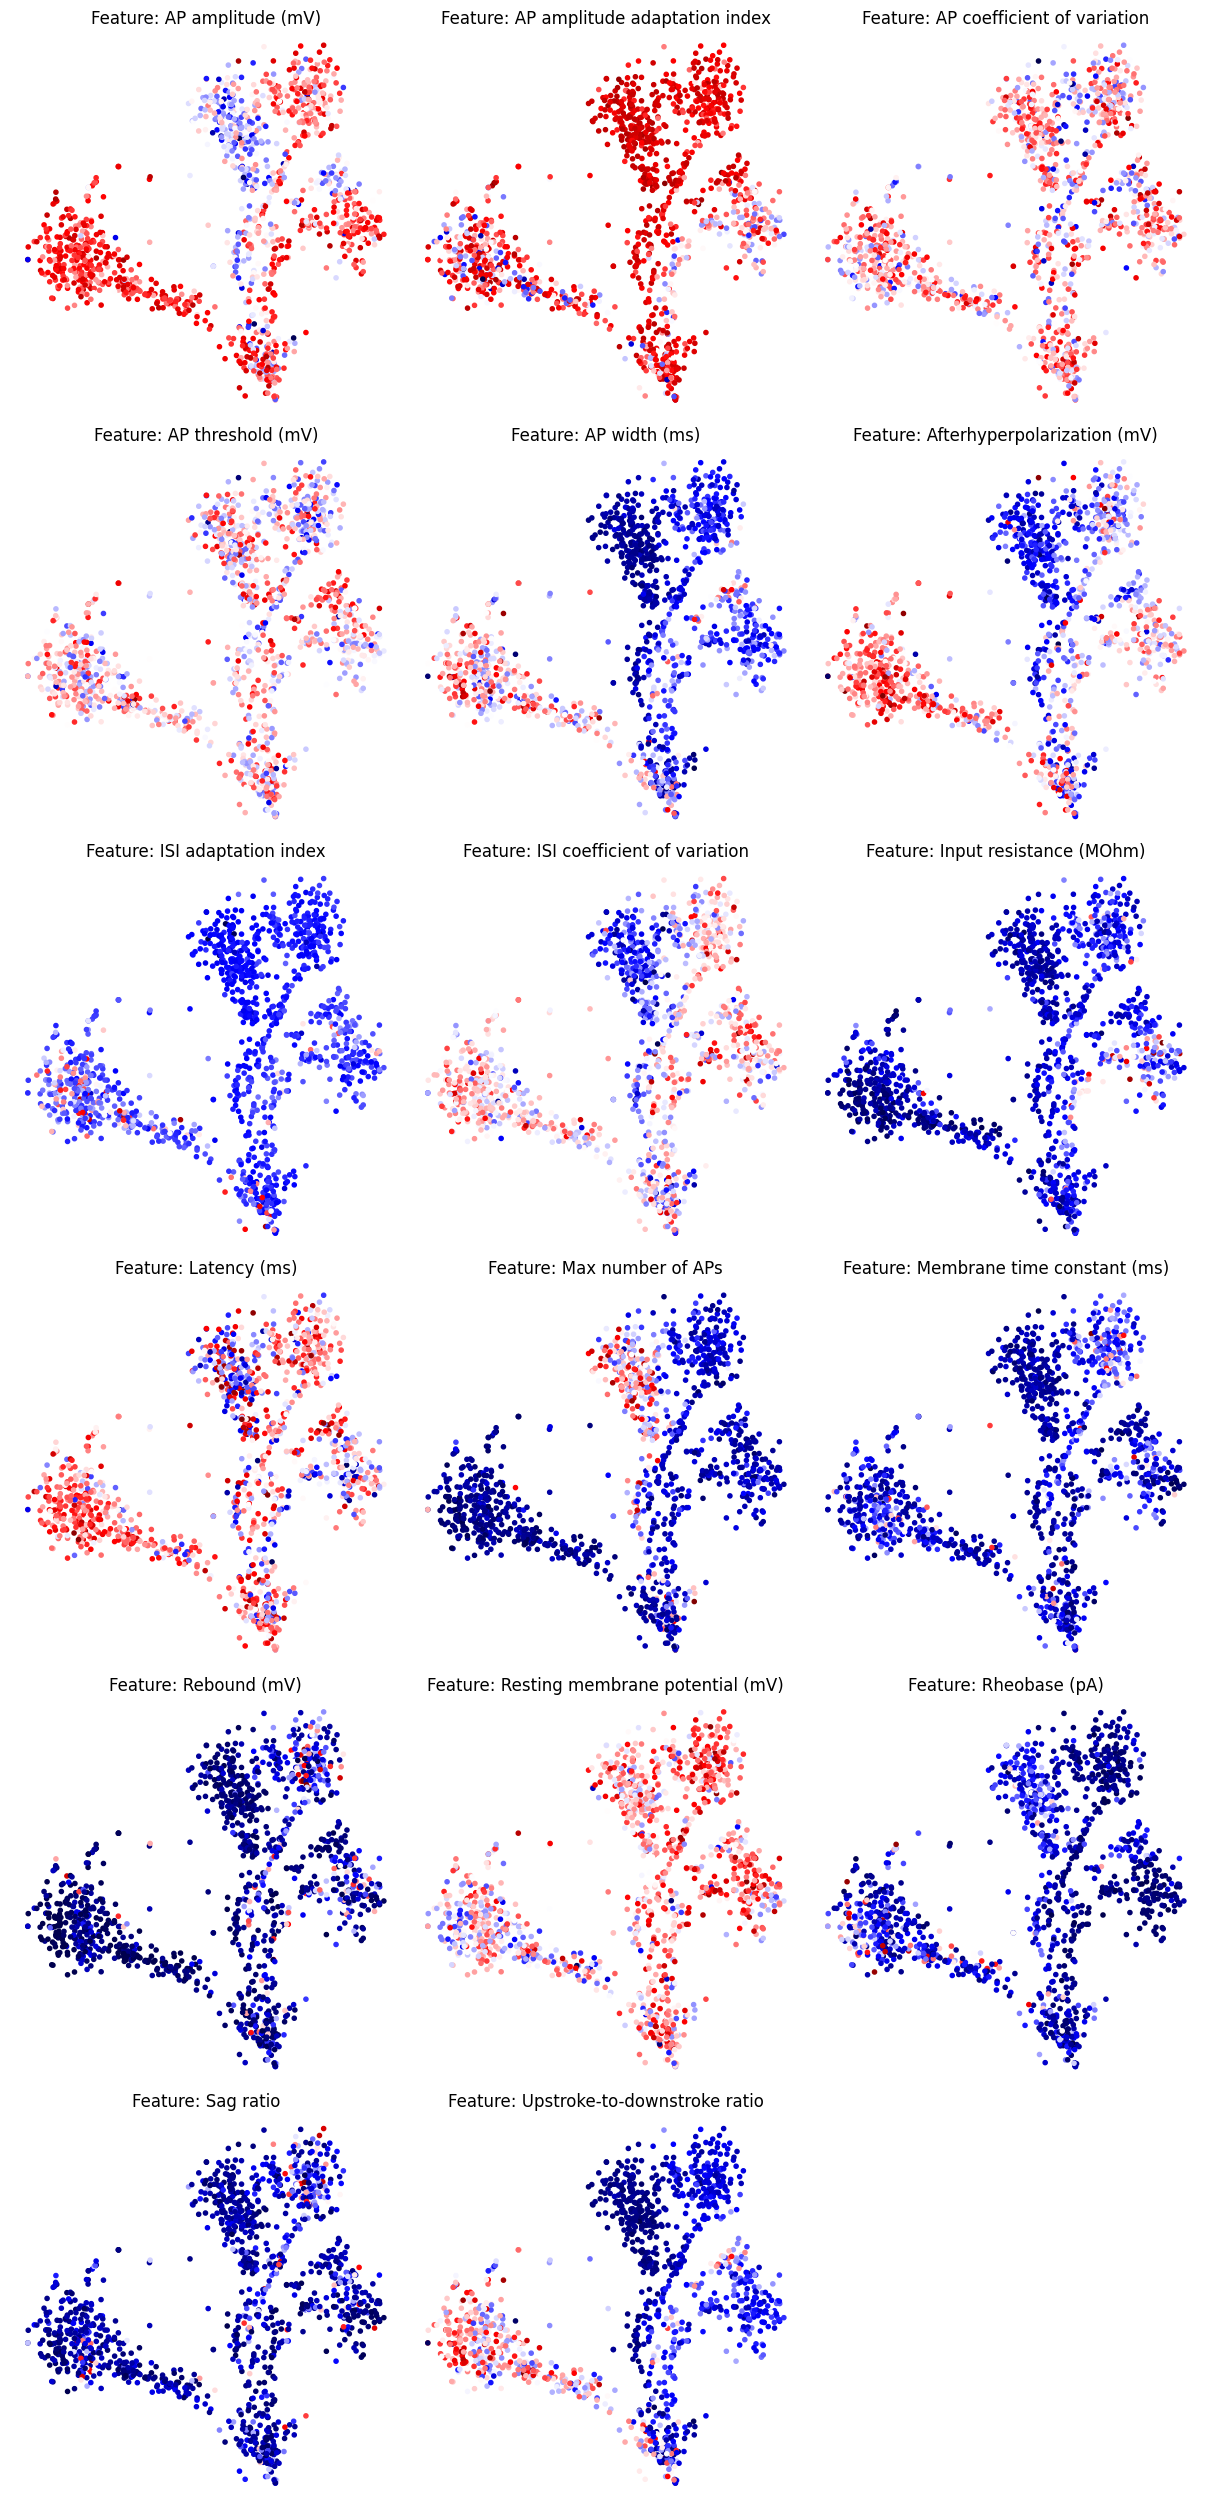

In [36]:
from matplotlib.colors import Normalize

fig, axes = plt.subplots(6, 3, figsize=(12, 25))
axes_flat = np.ravel(axes)
pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
    data_final[keepcells]
)
tsne = sklearn.manifold.TSNE(
    n_components=2, perplexity=perplexity, random_state=7
)
tsne_results = tsne.fit_transform(pca_result)


for idx in range(0, len(X[0, :])):
    ax = axes_flat[idx]
    x = X[:, idx]
    norm = Normalize(vmin=min(x), vmax=max(x))
    colors = plt.cm.seismic(norm(x))

    ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=colors)
    ax.set_title(
        f"Feature: {ephysNames[idx]}",
        fontsize=12,
    )
    ax.axis("off")
axes_flat[17].axis("off")
plt.show()

/opt/homebrew/Caskroom/miniconda/base/envs/nds_env/lib/python3.10/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


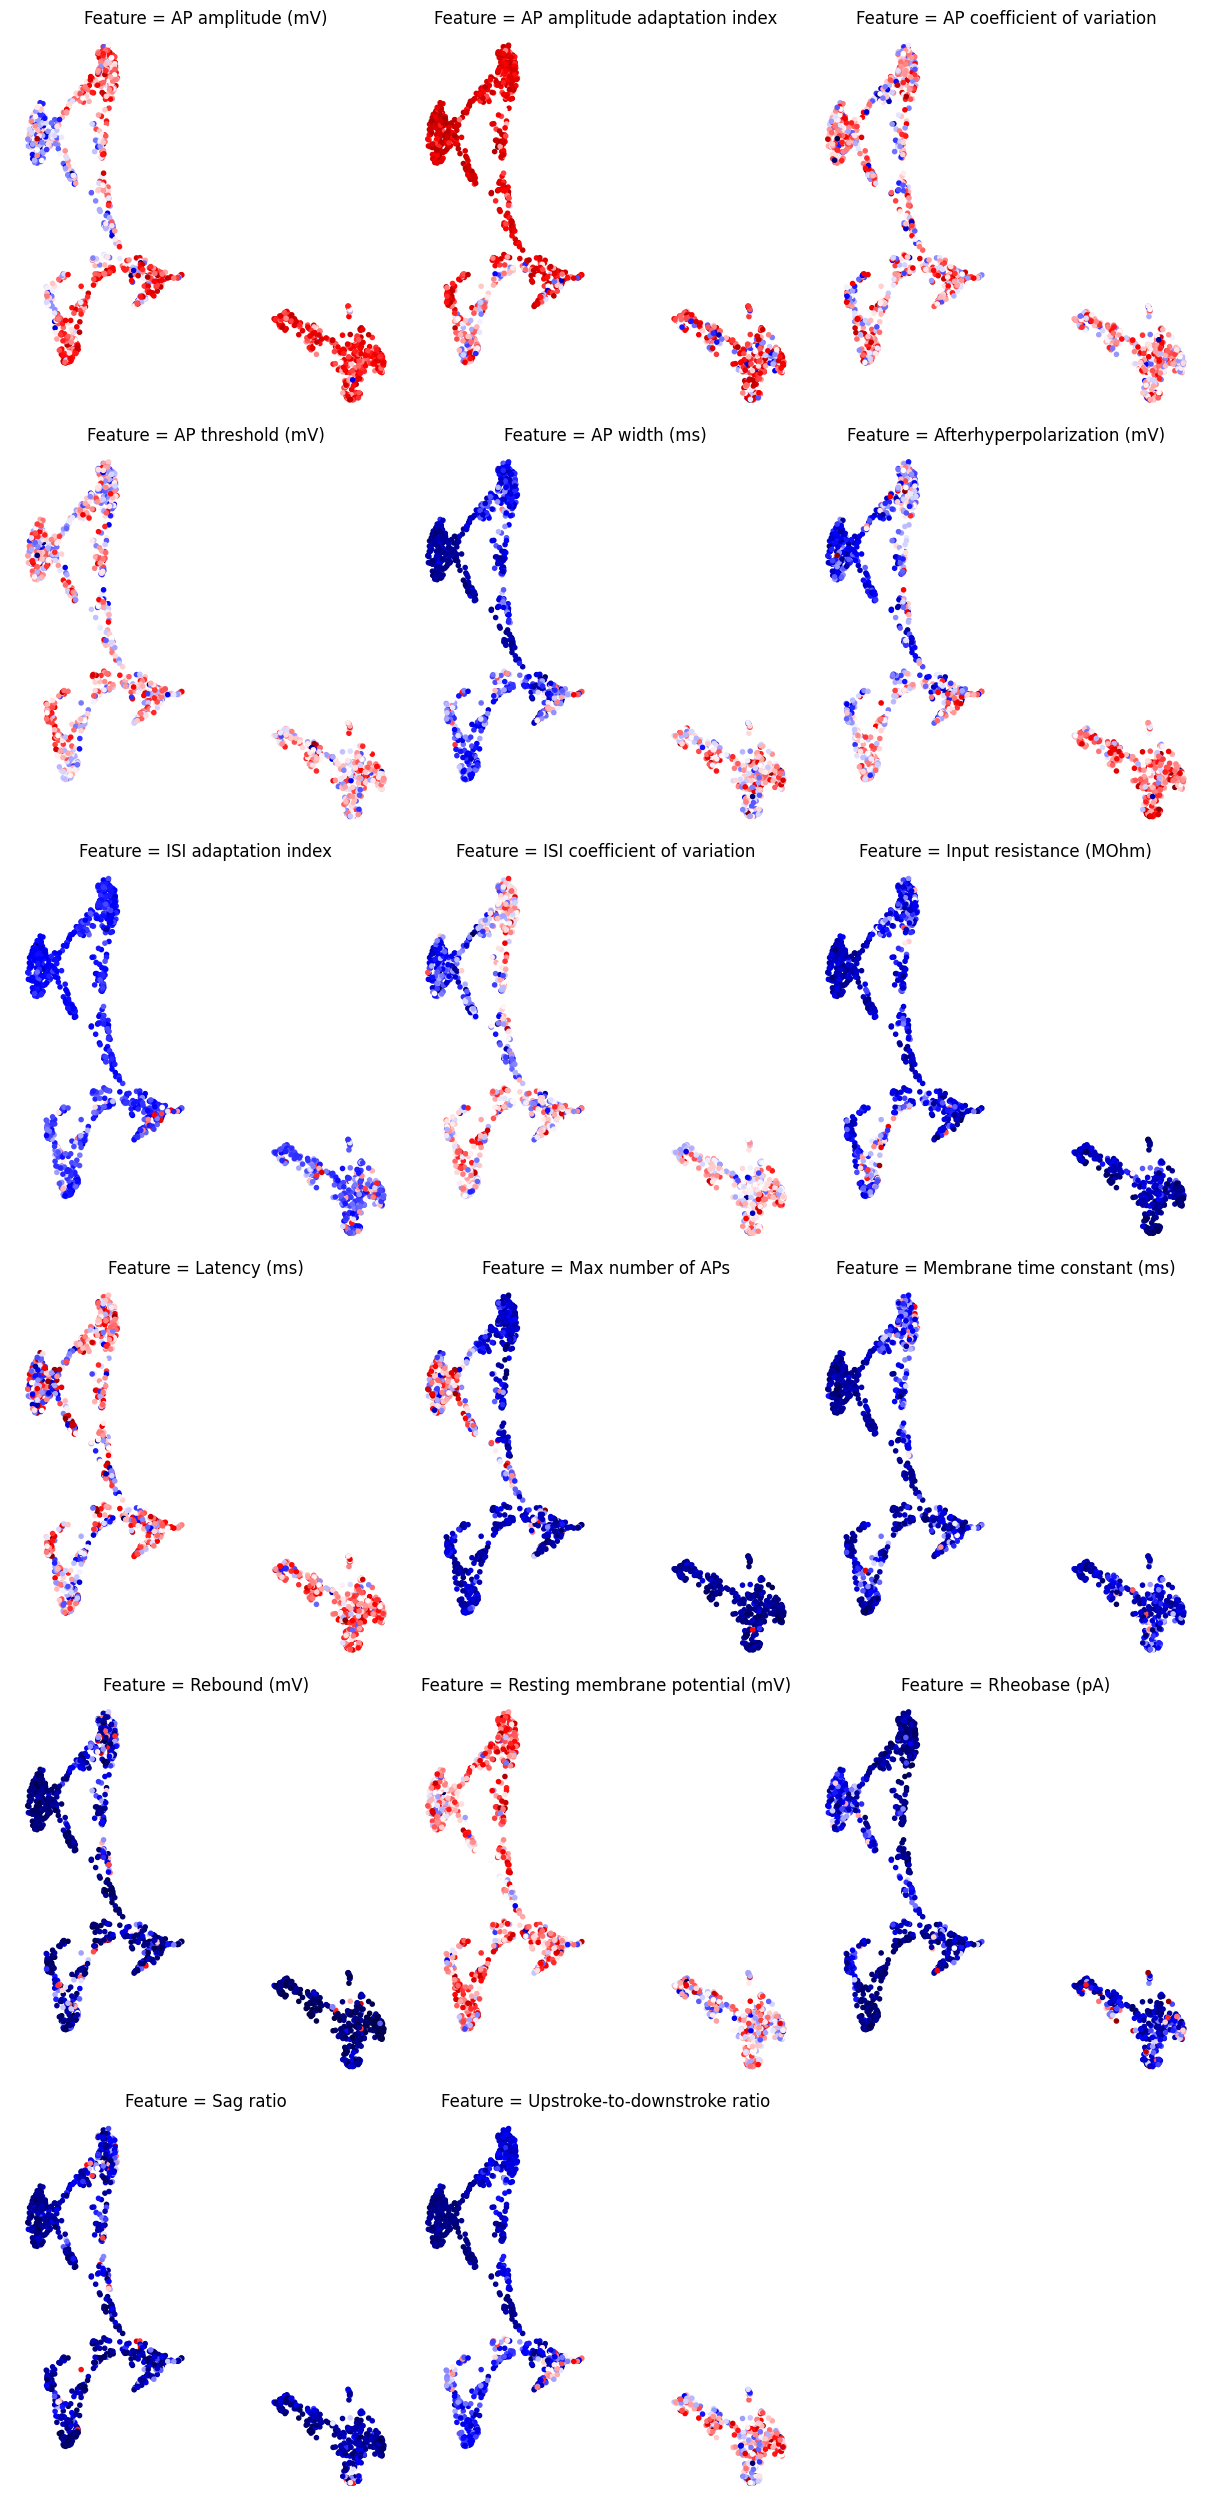

In [37]:
fig, axes = plt.subplots(6, 3, figsize=(12, 25))
axes_flat = np.ravel(axes)

umap_model = umap.UMAP(random_state=7)
umap_results = umap_model.fit_transform(pca_result)

for idx in range(0, len(X[0, :])):
    ax = axes_flat[idx]
    x = X[:, idx]
    norm = Normalize(vmin=min(x), vmax=max(x))
    colors = plt.cm.seismic(norm(x))

    ax.scatter(umap_results[:, 0], umap_results[:, 1], c=colors)
    ax.set_title(
        f"Feature = {ephysNames[idx]}",
        fontsize=12,
    )
    ax.axis("off")
axes_flat[17].axis("off")
plt.show()

## 4) Clustering ##

Based on the results before, we continue the analysis with the CPMedian normalization and the log transform (data_final). In total we try three different clustering approaches: 
1. Leidenclustering 
2. Gaussian mixture model 
3. negative binomial mixture model \

Each method has different hyperparamters that in the end define how many clusters will be identified. To find the hyperparameters we consider different metricies: 

* silhouette-score  
* adjusted rand index 
* davies-bouldin score 
* baysian information criterion (The BIC was only calculated for the mixture models, sind leiden clustering naturally does not return a likelihood for the clustering)

### True Cluster inspection

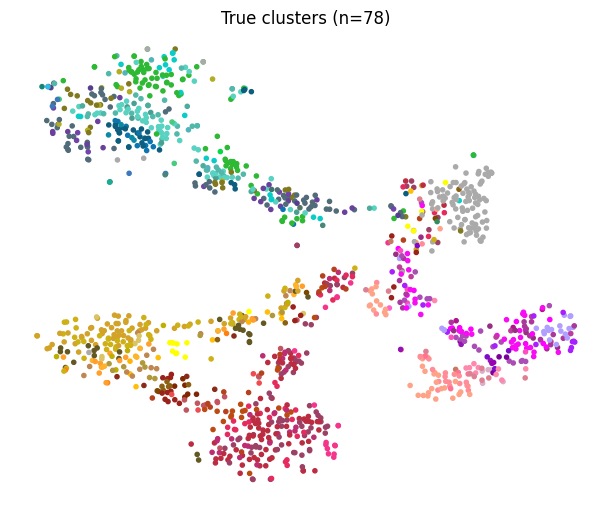

silhouette score: 	-0.10
davies-boulding score: 	4.01


In [51]:
# transform the cluster colors into an array of cluster numbers
n_cells = data_final.shape[0]
true_labels = np.zeros(n_cells)
for i in range(n_cells):
    true_labels[i] = np.argwhere(
        np.unique(cluster_colors) == cluster_colors[i]
    )[0, 0]

# caclulate metricies that dont need a reference/likelihood
sil_score = sklearn.metrics.silhouette_score(data_final, true_labels)
db_score = sklearn.metrics.davies_bouldin_score(data_final, true_labels)

# plot true clusters
pca_result = sklearn.decomposition.PCA(n_components=50).fit_transform(
    data_final
)
tsne = sklearn.manifold.TSNE(n_components=2, perplexity=30, random_state=7)
tsne_results = tsne.fit_transform(pca_result)
fig, ax = plt.subplots(1, 1, figsize=(6, 5))
ax.set_title(f"True clusters (n={len(np.unique(cluster_colors))})")
ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
ax.axis("off")
plt.show()

print(f"silhouette score: \t{sil_score:.2f}")
print(f"davies_bouldin score: \t{db_score:.2f}")

The authors identify 78 differenct clusters. We will use this cluster assignment as true clusters in our following evaluation of the cluster algorithms. \
One can see that the clusters are separated, but still overlap. Additionally, n=78 are a lot of clusters. We calculated the silhouette score and the davies-bouldin score for the original data and get quite bad values, which indicate that those metricies may not be very suitable for our dataset to evaluate the clustering performance. These metricies rely on the distances between samples and the clusters and therefore might not be able to capture non spherical clusters and clusters with different widths. Since the calculated values on our assumed true clusertings are quite bad, we think that these metrices are not suitable for our data set. Therefore, we dont use them in the further analysis. 

### GMM

We want to find the amount of components (=classes) in the GMM that gives the best clustering result. Therefore we fit the model multiple times using diffferent random seeds and amount of components and then inspect the adjust rand index and the bic values. 

In [74]:
## run GMM for various different components for N = 5 different random states
from sklearn.mixture import GaussianMixture
import tqdm

N_RUNS = 10
L_n_components = [
    2,
    3,
    4,
    5,
    6,
    7,
    8,
    9,
    10,
    11,
    12,
    13,
    14,
    15,
    20,
    30,
    50,
    70,
    100,
]


gmm_sil_scores = np.zeros((N_RUNS, len(L_n_components)))
gmm_db_scores = np.zeros((N_RUNS, len(L_n_components)))
gmm_ar_scores = np.zeros((N_RUNS, len(L_n_components)))
gmm_bic_scores = np.zeros((N_RUNS, len(L_n_components)))
for i in tqdm.tqdm(range(N_RUNS)):
    for j, n_components in enumerate(L_n_components):
        # fit GMM
        gmm = GaussianMixture(n_components=n_components, random_state=i).fit(
            data_final
        )

        # calculate different metrices
        gmm_sil_scores[i, j] = sklearn.metrics.silhouette_score(
            data_final, gmm.predict(data_final)
        )
        gmm_db_scores[i, j] = sklearn.metrics.davies_bouldin_score(
            data_final, gmm.predict(data_final)
        )
        gmm_ar_scores[i, j] = sklearn.metrics.adjusted_rand_score(
            true_labels, gmm.predict(data_final)
        )
        gmm_bic_scores[i, j] = gmm.bic(data_final)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [06:32<00:00, 39.24s/it]


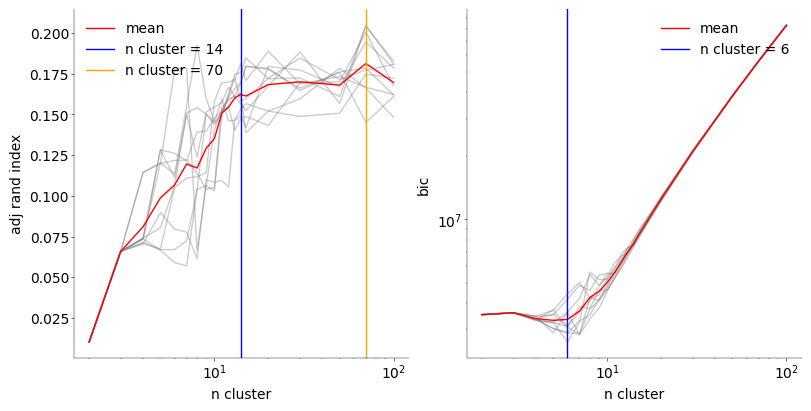

In [111]:
# plot the different metrices

metrices = [gmm_ar_scores, gmm_bic_scores]
metrices_names = ["adj rand index", "bic"]

fig, axs = plt.subplots(1, len(metrices), figsize=(8, 4), sharex=True)
for i, ax in enumerate(axs):
    for j in range(N_RUNS):
        ax.plot(L_n_components, metrices[i][j, :], color="gray", alpha=0.4)
    ax.plot(
        L_n_components, np.mean(metrices[i], axis=0), color="red", label="mean"
    )
    ax.set_ylabel(metrices_names[i])
    ax.set_xscale("log")
    ax.set_xlabel("n cluster")

# add specific visuals
axs[0].axvline(14, color="blue", label="n cluster = 14")
axs[0].axvline(70, color="orange", label="n cluster = 70")
axs[0].legend(loc="upper left")
axs[1].axvline(6, color="blue", label="n cluster = 6")
axs[1].legend(loc="upper right")
axs[1].set_yscale("log")

For the adjusted rand index we can see that the value rises roughly until 14 clusters and then starts to plateau. This indicates that more components than 14 dont increase the clustering performance. However, even for 10 runs there is a jump in the mean adj rand index value at 70 clusters, which can be seen in many trials. \
The bic has a minimum at 6 clusters, meaning that 6 clusters are a good trade off between model complexity and likelihood. \
To evaluate that further we visually inspect the clusterings for the best runs for 6 (min bic), 14 and 70 clusters (max adj run index).

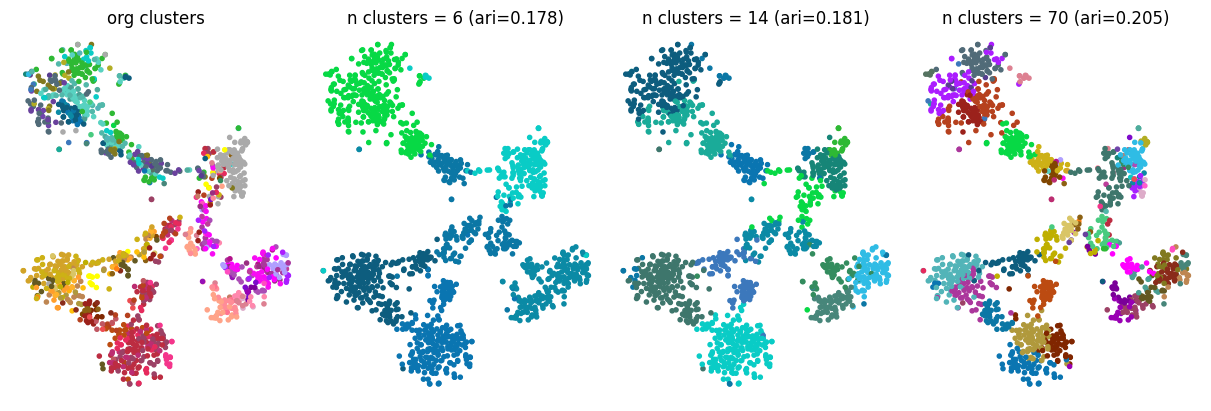

In [213]:
best_gmm_clusters = []
best_gmm_ari = 0

min_bic_6 = np.argmin(
    gmm_bic_scores[:, np.argwhere(np.array(L_n_components) == 6)[0, 0]]
)
max_ari_14 = np.argmax(
    gmm_ar_scores[:, np.argwhere(np.array(L_n_components) == 14)[0, 0]]
)
max_ari_70 = np.argmax(
    gmm_ar_scores[:, np.argwhere(np.array(L_n_components) == 70)[0, 0]]
)
n_components = [6, 14, 70]
random_seeds = [min_bic_6, max_ari_14, max_ari_70]

fig, axs = plt.subplots(1, 4, figsize=(12, 4))

axs[0].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=cluster_colors,
)
axs[0].set_title("org clusters")
axs[0].axis("off")
for i, ax in enumerate(axs[1:]):
    clusters = GaussianMixture(
        n_components=n_components[i], random_state=random_seeds[i]
    ).fit_predict(data_final)

    ari = sklearn.metrics.adjusted_rand_score(true_labels, clusters)
    ax.scatter(
        tsne_results[:, 0],
        tsne_results[:, 1],
        c=np.unique(cluster_colors)[clusters],
    )
    ax.axis("off")
    ax.set_title(f"n clusters = {n_components[i]} (ari={ari:.3f})")

    # store best GMM clusters
    if i == 2:
        best_gmm_clusters = clusters
        best_gmm_ari = ari

The clustering for 6 clusters does capture a broad structure, so that close samples in the 2d visualization mostly are assigned to the same cluster. However, there are many clusters that are merged together. For 16 clusters, one can see certain structure that are identified similar to the original clusters. E.g. the cluster on the right bottom, is represented by 3 distinct clusters, which looks kind of similar to the orignal clusters. For 70 clusters, it is quite hard to visually say how good the clustering result is. However, the marginal improvement in ari in relation to the significant increase in model complexity, underlines that this clustering method does not seem to be an effective method for this data set.

### Leiden 
For Leiden clustering, one does not specify the amount of clusters before, but an resolution parameter, upon which the amount of clusters depend. To find an appropriate resolution, we use the ari as metric and run the clustering approach mutliple times with different random seeds 

In [142]:
### Leiden
import igraph as ig
from sklearn.neighbors import kneighbors_graph
import leidenalg as la
import sklearn.metrics
import tqdm

A = kneighbors_graph(data_final, 15)
sources, targets = A.nonzero()
A = ig.Graph(zip(sources, targets))

resolutions = np.arange(0.1, 20, 0.5)

leiden_ar_scores = np.zeros((N_RUNS, len(resolutions)))
for i in tqdm.tqdm(range(N_RUNS)):
    for j, resolution in enumerate(resolutions):
        partition = la.find_partition(
            A,
            la.RBConfigurationVertexPartition,
            resolution_parameter=resolution,
            seed=i,
        )
        leiden_ar_scores[i, j] = sklearn.metrics.adjusted_rand_score(
            true_labels, partition.membership
        )

100%|██████████| 10/10 [00:28<00:00,  2.82s/it]


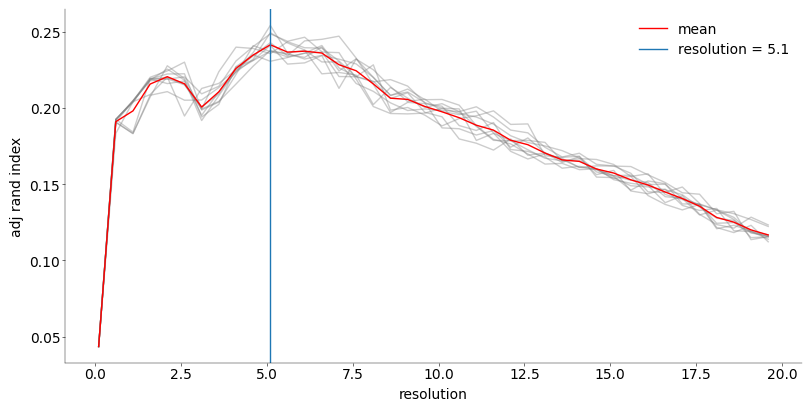

In [154]:
# plot the different metrices

metrices_names = ["adj rand index"]

plt.figure(figsize=(8, 4))
for j in range(N_RUNS):
    plt.plot(resolutions, leiden_ar_scores[j, :], color="gray", alpha=0.4)
plt.plot(
    resolutions, np.mean(leiden_ar_scores, axis=0), color="red", label="mean"
)
plt.ylabel("adj rand index")
plt.xlabel("resolution")

# add specific visuals
plt.axvline(5.1, color="blue", label="resolution = 5.1")
plt.legend(loc="upper right")
plt.show()

One can see that there is relatively little variance in the adjusted rand index value for different random seeds. The largers mean ari value is obtained at a resolution of 5.1, with ~0.24, which is higher then for the GMM models. We now want to inspect the clustering with the highest ari visually.

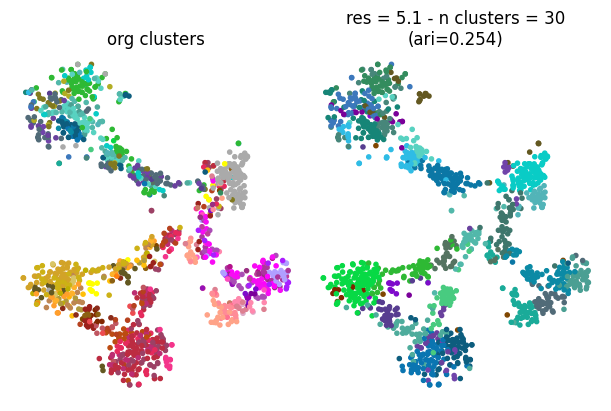

In [216]:
seed = np.argmax(
    leiden_ar_scores[:, np.argwhere(np.array(resolutions) == 5.1)[0, 0]]
)
partition = la.find_partition(
    A,
    la.RBConfigurationVertexPartition,
    resolution_parameter=5.1,
    seed=seed,
)
ari = sklearn.metrics.adjusted_rand_score(true_labels, partition.membership)
best_leiden_clusters = partition.membership
best_leiden_ari = ari

fig, axs = plt.subplots(1, 2, figsize=(6, 4))
axs[0].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=cluster_colors,
)
axs[1].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=np.unique(cluster_colors)[partition.membership],
)
axs[0].set_title("org clusters")
axs[1].set_title(
    f"res = 5.1 - n clusters = {len(np.unique(partition.membership))}\n(ari={ari:.3f})"
)
axs[0].axis("off")
axs[1].axis("off")
plt.show()

One can see that the overall clustering looks kind of similar to the original clustering.

### Negative Binomial mixture model
We implemented a version of a negative binomial mixture model following the papers instructions. We avoided the optimization of the number of cluster but instead gave the nnumber of cluster as hyper parameter. Since the model runs quite long, we evaluate the adjusted rand index for a set of 4-2 clusters for 3 times (took ~15min).

In [169]:
# negative binomial model implementation
from sklearn.cluster import KMeans


# calculate posteriors using bayes
def e_step(data, ps, pis):
    n_cells = data.shape[0]
    n_genes = data.shape[1]
    n_cluster = len(pis)

    # log likelihood
    gamma = np.zeros((n_cells, n_cluster))
    for i in range(n_cells):
        for k in range(n_cluster):
            gamma[i, k] = np.log(pis[k]) + np.sum(
                [
                    data[i, g] * np.log(ps[k, g]) + 2 * np.log(1 - ps[k, g])
                    for g in range(n_genes)
                ]
            )

    # "hard EM"
    clusters = np.array([np.argmax(x) for x in gamma])

    return clusters


def m_step(data, clusters, n_cluster):
    n_cells = data.shape[0]
    n_genes = data.shape[1]

    ps = np.zeros((n_cluster, n_genes))

    # priors
    pis = [np.sum(clusters == c) / n_cells for c in range(n_cluster)]

    # calculcate max likelihood estimates for p
    for i in range(n_cluster):
        for g in range(n_genes):
            mu = (np.sum(data[clusters == i, g]) + 10**-4) / (
                1 + np.sum(clusters == i)
            )
            ps[i, g] = mu / (2 + mu)

    return [pis, ps]


def neg_binom_model(data, n_cluster, seed=1, r=2, max_iter=100):

    n_cells = data.shape[0]
    n_genes = data.shape[1]

    # init
    ps = np.random.rand(n_cluster, n_genes)
    pis = np.ones(n_cluster) / n_cluster

    kmeans = KMeans(
        n_clusters=n_cluster, random_state=seed, n_init="auto"
    ).fit(data)
    clusters = kmeans.labels_
    clusters_old = clusters

    # fit model
    for i in range(max_iter):

        # m step
        [pis, ps] = m_step(data, clusters, n_cluster)

        # e step
        clusters = e_step(data, ps, pis)

        if i != 0:
            conv = np.sum(clusters_old == clusters) / len(clusters)
            if conv > 0.99:
                return clusters

        clusters_old = clusters

    return clusters

In [183]:
N_RUNS = 3
NB_n_clusters = [4, 6, 8, 10, 12, 14, 20]

nb_ar_scores = np.zeros((N_RUNS, len(NB_n_clusters)))
for i in tqdm.tqdm(range(N_RUNS)):
    for j, n_cluster in enumerate(NB_n_clusters):

        clusters = neg_binom_model(data_final, n_cluster, seed=i)

        nb_ar_scores[i, j] = sklearn.metrics.adjusted_rand_score(
            true_labels, clusters
        )

100%|██████████| 3/3 [12:24<00:00, 248.21s/it]


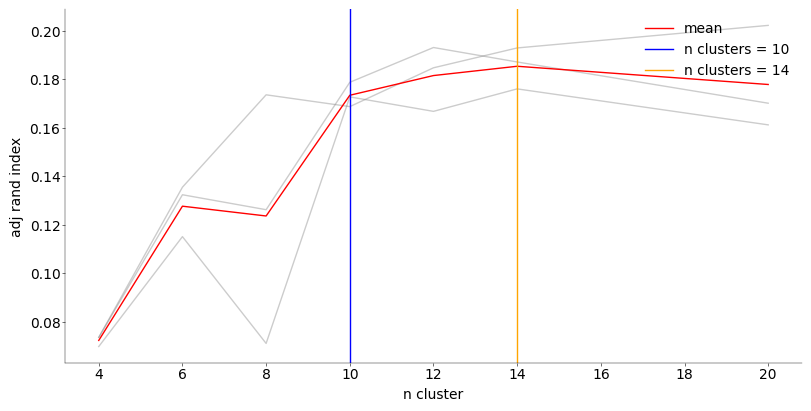

In [189]:
# plot the different metrices

metrices_names = ["adj rand index"]

plt.figure(figsize=(8, 4))
for j in range(N_RUNS):
    plt.plot(NB_n_clusters, nb_ar_scores[j, :], color="gray", alpha=0.4)
plt.plot(
    NB_n_clusters,
    np.mean(nb_ar_scores, axis=0),
    color="red",
    label="mean",
)
plt.ylabel("adj rand index")
plt.xlabel("n cluster")

# # add specific visuals
plt.axvline(10, color="blue", label="n clusters = 10")
plt.axvline(14, color="orange", label="n clusters = 14")
plt.legend(loc="upper right")
plt.show()

It can be seen that the ari increases with a larger cluster amount and seems to plateau after 14 clusters. We want to inspect visally the best clustering for 10 clusters, which looks like the point where the ari does not increases a lot with increasing cluster size and for 14 clusters, which seem to have on average the best ari.

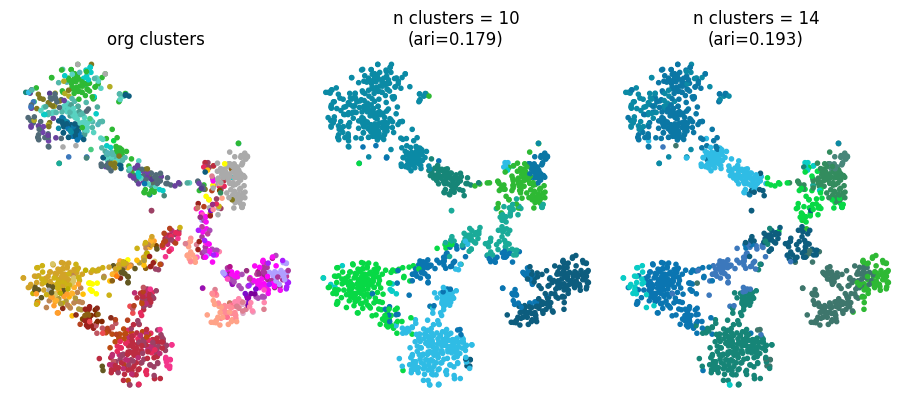

In [220]:
best_nb_clusters = []
best_nb_ari = 0

clusters_inspect = [10, 14]

fig, axs = plt.subplots(1, 3, figsize=(9, 4))
axs[0].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=cluster_colors,
)
axs[0].set_title("org clusters")
axs[0].axis("off")

for i, cluster_n in enumerate(clusters_inspect):
    seed = np.argmax(
        nb_ar_scores[
            :, np.argwhere(np.array(NB_n_clusters) == cluster_n)[0, 0]
        ]
    )

    clusters = neg_binom_model(data_final, cluster_n, seed=seed)

    ari = sklearn.metrics.adjusted_rand_score(true_labels, clusters)

    axs[i + 1].scatter(
        tsne_results[:, 0],
        tsne_results[:, 1],
        c=np.unique(cluster_colors)[clusters],
    )
    axs[i + 1].axis("off")
    axs[i + 1].set_title(f"n clusters = {cluster_n}\n(ari={ari:.3f})")

    if i == 1:
        best_nb_clusters = clusters
        best_nb_ari = ari

plt.show()

The clustering for 10 and 14 clusters does not seem really good. Again close points in our 2d visualization typically belong to the same cluster, but many clusters from the orignal cluster labels are merged together. Additionally, e.g. on the top right there is a cluster in the true clusters that is splitted for the case of 10 clusters. 

### Comparison

While trying different metrices, we found that the adjusted rand index was best suited for our data set. Since the different clustering methods performed very different depending on their hyperparameters, we tried to find the best hyperparameters for each method by considering multiple runs with different seeds and mainly the adjusted rand index. From visual inpsection and also from absolute values, leiden clustering seems to replicate the true clusterings best, with a resolution of 5.1, which results in 30 clusters. However the difference in absolute ari value is not very large. 

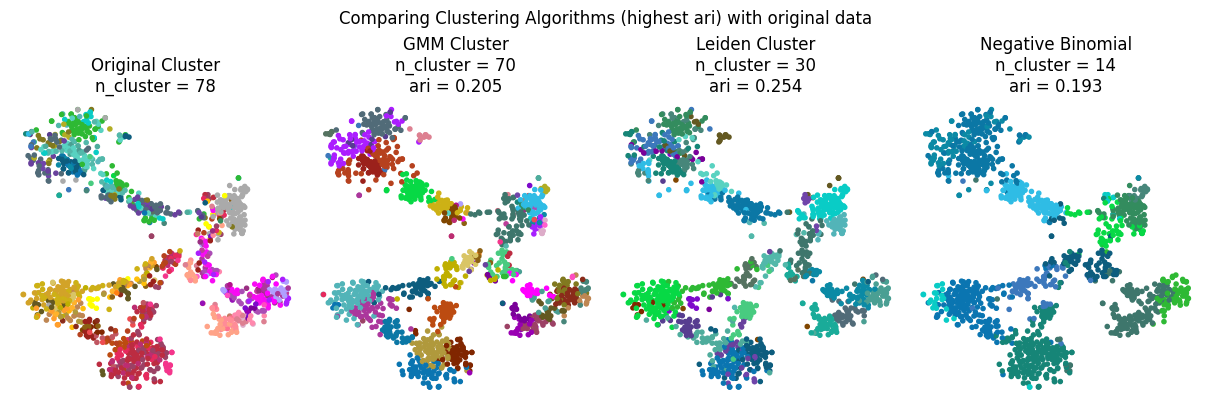

In [221]:
fig, axes = plt.subplots(1, 4, figsize=(12, 4))
fig.suptitle(
    "Comparing Clustering Algorithms (highest ari) with original data"
)


axes[0].scatter(tsne_results[:, 0], tsne_results[:, 1], c=cluster_colors)
axes[1].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=np.unique(cluster_colors)[best_gmm_clusters],
)
axes[2].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=np.unique(cluster_colors)[best_leiden_clusters],
)
axes[3].scatter(
    tsne_results[:, 0],
    tsne_results[:, 1],
    c=np.unique(cluster_colors)[best_nb_clusters],
)

axes[0].set_title(
    f"Original Cluster\nn_cluster = {len(np.unique(cluster_colors))}"
)
axes[1].set_title(
    f"GMM Cluster\nn_cluster = {len(np.unique(best_gmm_clusters))}\nari = {best_gmm_ari:.3f}"
)
axes[2].set_title(
    f"Leiden Cluster\nn_cluster = {len(np.unique(best_leiden_clusters))}\nari = {best_leiden_ari:.3f}"
)
axes[3].set_title(
    f"Negative Binomial\nn_cluster = {len(np.unique(best_nb_clusters))}\nari = {best_nb_ari:.3f}"
)

axes[0].axis("off")
axes[1].axis("off")
axes[2].axis("off")
axes[3].axis("off")
plt.show()

## 5) Correlation

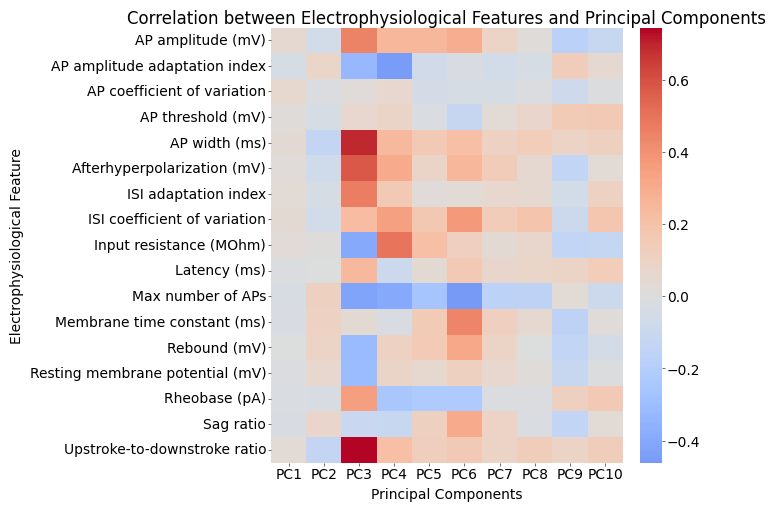

PCs with highest correlation in electrophysiological features: [0.01579773 0.09753815 2.67789968 1.1301288  0.37589762 1.08598671
 0.14954285 0.12318764 0.23356312 0.1858429 ]


In [ ]:
from scipy.stats import pearsonr

counts = data_final[keepcells]

n_components = 10
pca = PCA(n_components=n_components)
pcs = pca.fit_transform(counts)

combined_data = np.hstack((pcs, X))

correlations = np.zeros((X.shape[1], pcs.shape[1]))
p_values = np.zeros((X.shape[1], pcs.shape[1]))

for i in range(X.shape[1]):
    for j in range(pcs.shape[1]):
        corr, p_value = pearsonr(X[:, i], pcs[:, j])
        correlations[i, j] = corr
        p_values[i, j] = p_value
plt.figure(figsize=(7, 5))
sns.heatmap(
    correlations,
    annot=False,
    cmap="coolwarm",
    center=0,
    xticklabels=[f"PC{j+1}" for j in range(pcs.shape[1])],
    yticklabels=[ephysNames[idx] for idx in range(len(ephysNames))],
)
plt.title(
    "Correlation between Electrophysiological Features and Principal Components"
)
plt.xlabel("Principal Components")
plt.ylabel("Electrophysiological Feature")
plt.show()
print(
    f"PCs with highest correlation in electrophysiological features: {sum(correlations**2)}"
)

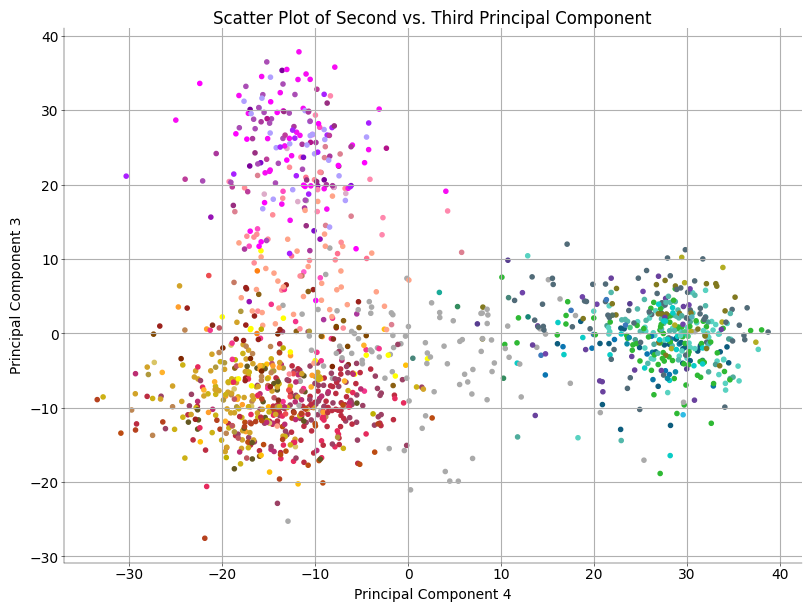

In [ ]:
pc2 = pcs[:, 2]
pc3 = pcs[:, 3]

# Create a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(
    pc2, pc3, c=cluster_colors[keepcells]
)  # Adjust alpha and s for aesthetics
plt.title("Scatter Plot of Second vs. Third Principal Component")
plt.xlabel("Principal Component 4")
plt.ylabel("Principal Component 3")
plt.grid(True)
plt.show()

/var/folders/5j/y5kkrfqd203frqztz88nnmqr0000gn/T/ipykernel_74131/3476536929.py:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


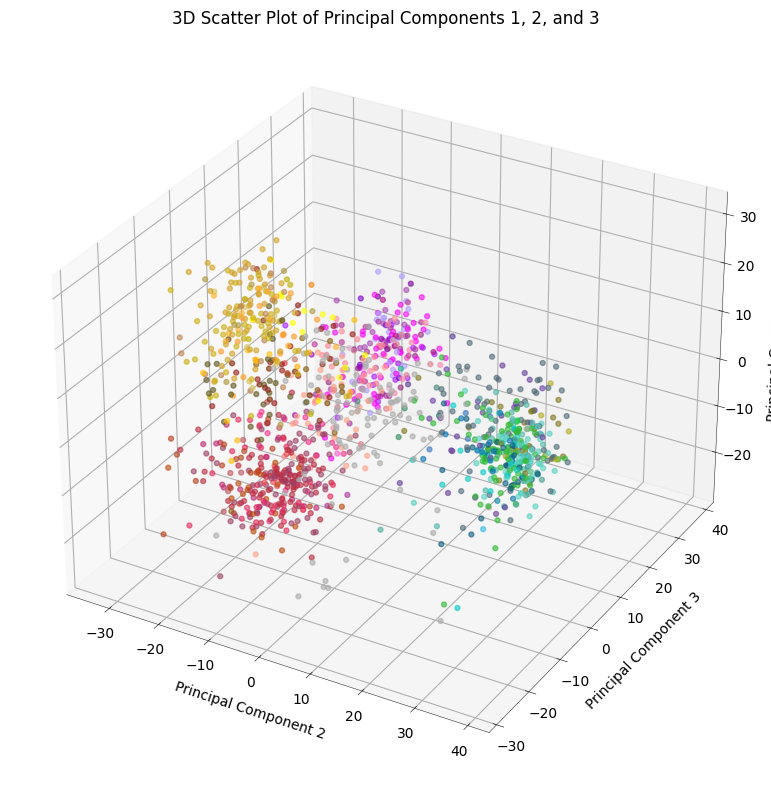

In [ ]:
pc2 = pcs[:, 2]
pc3 = pcs[:, 3]
pc5 = pcs[:, 5]

# Create a 3D scatter plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
sc = ax.scatter(pc2, pc3, pc5, c=cluster_colors[keepcells], alpha=0.6, s=50)

# Add labels and title
ax.set_title("3D Scatter Plot of Principal Components 1, 2, and 3")
ax.set_xlabel("Principal Component 2")
ax.set_ylabel("Principal Component 3")
ax.set_zlabel("Principal Component 5")
plt.tight_layout()
plt.show()

## To Dos

- BIC oder irgendwas anderes statt silhouette score?
- NBB clustering
- PCAs zurückrechnen auf gene

- Schreiben!